# Kalibrasi FHP dengan pendekatan ANN

Kalibrasi FHP dilakukan dengan langkah seperti berikut:

1. Mengumpulkan data hasil pengujian di terowongan angin yang merupakan nilai tekanan terukur pada setiap lubang probe untuk setiap posisi sudut serang, sudut selip, dan kecepatan aliran tertentu.
2. Melakukan pengecekan data mirroring untuk setiap posisi yang bersesuaian.
3. Melakukan pengujian untuk satu kuadran yang diwakili oleh sudut serang dengan range 0 s/d 20 interval 5 derajat, sudut selip dengan range 0 s/d 90 interval 5 derajat, dan kecepatan dengan range 10 s/d 50 interval 10 m/s.
4. Melakukan pengujian untuk kuadran lainnya yang diwakili oleh sudut serang dengan range (-20) s/d 20 interval 10 derajat, sudut selip dengan range 0 s/d (-30) interval 5 derajat, dan kecepatan dengan range 10 s/d 50 interval 10 m/s.
5. Mengelompokkan data tekanan yang terukur dengan posisi sudut serang, sudut selip, dan kecepatan yang aktual.
6. Melakukan proses normalisasi data.

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random, time
from mpl_toolkits.mplot3d import Axes3D
from hyperopt import fmin, tpe, hp, Trials
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import load_model

In [2]:
import os

# Menampilkan current working directory
print("Current Working Directory:", os.getcwd())

# Mengubah working directory
new_directory = 'C:/Users/AbdurrahmanBirry/OneDrive - Institut Teknologi Bandung/Sem 4/Tesis 2'  # Ganti dengan path direktori yang Anda inginkan
os.chdir(new_directory)

# Menampilkan current working directory setelah diubah
print("New Working Directory:", os.getcwd())




Current Working Directory: C:\Users\AbdurrahmanBirry\OneDrive - Institut Teknologi Bandung\Sem 4\Tesis 2
New Working Directory: C:\Users\AbdurrahmanBirry\OneDrive - Institut Teknologi Bandung\Sem 4\Tesis 2


In [3]:
import os

# Menampilkan current working directory
print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Users\AbdurrahmanBirry\OneDrive - Institut Teknologi Bandung\Sem 4\Tesis 2


## Load semua data dan digabungkan menjadi satu dataframe

In [4]:
# Set options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
# Specify the directory containing the Excel files
#excel_files_directory = 'C:/Users/AbdurrahmanBirry/OneDrive - Institut Teknologi Bandung/Sem 4/Tesis 2'
excel_files_directory = 'C:/Users/user/OneDrive - Institut Teknologi Bandung/Sem 4/Tesis 2'

# List to store individual DataFrames
data_frames = []

# Loop through the Excel files in the directory
for filename in os.listdir(excel_files_directory):
    if filename.endswith(".xlsx"):  # Make sure only Excel files are considered
        excel_file_path = os.path.join(excel_files_directory, filename)
        df = pd.read_excel(excel_file_path)
        data_frames.append(df)

# Concatenate all DataFrames into one
combined_df = pd.concat(data_frames, ignore_index=True)

# Display the combined DataFrame
#combined_df

In [7]:
# Semua data yang akan diolah
Data_All = combined_df.drop(columns=['EM','temp','ρ','Q'])
Data_All


a1       b1       a2       b2     pt-l     ps-l    pt-wt    ps-wt  \
0     0.00842  0.00000  0.00337  0.00842  0.05892  0.00673  0.06060  0.00000   
1     0.01010  0.00168  0.00337  0.00842  0.05724  0.00673  0.06060  0.00000   
2     0.00842  0.00337  0.00505  0.00842  0.05892  0.00842  0.06060  0.00168   
3     0.01010  0.00168  0.00337  0.00842  0.05724  0.00842  0.06060  0.00168   
4     0.01178  0.00337  0.00337  0.00842  0.05724  0.00842  0.06060  0.00000   
5     0.00673  0.00168  0.00168  0.00673  0.05555  0.00673  0.05892 -0.00168   
6     0.00842  0.00505  0.00505  0.00842  0.05892  0.00842  0.06060  0.00000   
7     0.00842  0.00505  0.00673  0.00842  0.05724  0.00842  0.06060  0.00000   
8     0.00842  0.00337  0.00673  0.00842  0.05892  0.00842  0.06060  0.00000   
9     0.00842  0.00168  0.00337  0.00842  0.05724  0.00842  0.06060  0.00000   
10    0.00673  0.01347  0.00168 -0.00505  0.05219  0.00673  0.06060 -0.00337   
11    0.00673  0.01178  0.00168 -0.00505  0.05219  0.00337  0.06060 -0.00337   
12    0.00673  0.01347  0.00000 -0.00505  0.05219  0.00505  0.05892 -0.00337   
13    0.00673  0.01347  0.00000 -0.00505  0.05050  0.00337  0.05892 -0.00337   
14    0.00673  0.01178  0.00000 -0.00505  0.05050  0.00505  0.06060 -0.00337   
15    0.00673  0.01347  0.00168 -0.00505  0.05387  0.00673  0.06060 -0.00337   
16    0.00673  0.01347  0.00168 -0.00505  0.05387  0.00505  0.06229 -0.00337   
17    0.00673  0.01347  0.00000 -0.00505  0.05387  0.00673  0.06060 -0.00168   
18    0.00842  0.01347  0.00168 -0.00505  0.05387  0.00505  0.06060 -0.00337   
19    0.00673  0.01347  0.00000 -0.00673  0.05219  0.00505  0.05892 -0.00337   
20    0.00000  0.02188 -0.00842 -0.01852  0.04714  0.00000  0.05387 -0.00673   
21    0.00168  0.02357 -0.00673 -0.01852  0.04714  0.00000  0.05555 -0.00337   
22    0.00000  0.02188 -0.00842 -0.01852  0.04714  0.00168  0.05555 -0.00505   
23    0.00168  0.02188 -0.00842 -0.01852  0.04714  0.00168  0.05724 -0.00505   
24    0.00000  0.02188 -0.00842 -0.01683  0.04714  0.00168  0.05555 -0.00505   
25    0.00168  0.02357 -0.00505 -0.01515  0.05050  0.00168  0.05724 -0.00337   
26    0.00168  0.02188 -0.00842 -0.01852  0.04714  0.00168  0.05555 -0.00505   
27    0.00337  0.02188 -0.00505 -0.01515  0.05050  0.00168  0.05724 -0.00505   
28    0.00168  0.02188 -0.00505 -0.01515  0.04714  0.00168  0.05724 -0.00505   
29    0.00168  0.02357 -0.00505 -0.01515  0.04882  0.00168  0.05724 -0.00505   
30    0.00000  0.03367 -0.00673 -0.02525  0.04545  0.00000  0.05892 -0.00337   
31    0.00000  0.03367 -0.00505 -0.02525  0.04545  0.00000  0.05892 -0.00337   
32    0.00000  0.03367 -0.00505 -0.02357  0.04545  0.00168  0.05724 -0.00337   
33    0.00168  0.03367 -0.00505 -0.02357  0.04882  0.00168  0.06060 -0.00168   
34    0.00000  0.03198 -0.00505 -0.02357  0.04714  0.00168  0.05892 -0.00337   
35    0.00000  0.03198 -0.00673 -0.02357  0.04714  0.00168  0.05892 -0.00168   
36    0.00168  0.03367 -0.00505 -0.02357  0.04714  0.00337  0.05892 -0.00337   
37    0.00168  0.03198 -0.00505 -0.02357  0.04714  0.00000  0.05892 -0.00337   
38    0.00168  0.03367 -0.00168 -0.02357  0.04714  0.00337  0.05892 -0.00337   
39    0.00168  0.03367 -0.00168 -0.02357  0.04714  0.00337  0.05892 -0.00337   
40   -0.00505  0.04040 -0.01178 -0.03198  0.04040 -0.00505  0.05555 -0.00505   
41   -0.00505  0.04040 -0.01010 -0.03367  0.04040 -0.00505  0.05555 -0.00505   
42   -0.00505  0.04040 -0.01010 -0.03198  0.04040 -0.00337  0.05555 -0.00505   
43   -0.00505  0.04040 -0.01010 -0.03198  0.03872 -0.00337  0.05555 -0.00505   
44   -0.00505  0.04040 -0.01178 -0.03030  0.03872 -0.00505  0.05387 -0.00505   
45   -0.00505  0.04040 -0.01010 -0.03198  0.03872 -0.00337  0.05555 -0.00505   
46   -0.00337  0.04209 -0.00842 -0.03030  0.03872 -0.00505  0.05555 -0.00505   
47   -0.00505  0.04209 -0.01010 -0.03198  0.03872 -0.00337  0.05724 -0.00505   
48   -0.00505  0.04209 -0.01010 -0.03198  0.03872 -0.00505  0.05555 -0.00673   
49   -0.003

In [6]:
# Memanggil file
Data_All = pd.read_csv('Data_All.csv')
Data_All = Data_All.rename(columns={'a1':'Pβ2','a2':'Pβ1','b1':'Pα1','b2':'Pα2','p3':'P3','Betha':'α','Alpha':'β'})
Data_All_copy = Data_All.copy()
Data_All_copy['β'] = Data_All_copy['β'] * (-1)

window_size = 10
Data_All_Avg = Data_All_copy.groupby(Data_All_copy.index // window_size).mean(numeric_only=True)
#Data_All_Avg = Data_All_Avg.rename(columns={'a1':'b1','a2':'b2','b1':'a1','b2':'a2','Betha':'α','Alpha':'β'})

Data_All_copy.to_csv('Data_All_rev.csv', index=False)
Data_All_Avg.to_csv('Data_All_Avg_rev.csv', index=False)

In [7]:
Data_All_Avg = pd.read_csv('Data_All_Avg_rev.csv')
Data_All_Avg

Pβ2       Pα1       Pβ1       Pα2        P3        ps     pt-wt  \
0    0.008923  0.002693  0.004209  0.008251  0.057743  0.007913  0.060432   
1    0.006899  0.013132  0.000840 -0.005218  0.052524  0.005218  0.060265   
2    0.001345  0.022387 -0.006903 -0.017003  0.047980  0.001344  0.056227   
3    0.000840  0.033163 -0.004712 -0.023906  0.046801  0.001683  0.058920   
4   -0.004714  0.040907 -0.010268 -0.031813  0.039224 -0.004378  0.055720   
5   -0.010605  0.045958 -0.015992 -0.040907  0.031814 -0.008080  0.054206   
6   -0.016328  0.051682 -0.021714 -0.047474  0.020872 -0.010941  0.056225   
7   -0.024242  0.053870 -0.028113 -0.056397  0.010772 -0.015150  0.056732   
8   -0.033164  0.054374 -0.037369 -0.063802 -0.000673 -0.019696  0.056225   
9   -0.039391  0.053534 -0.046295 -0.067508 -0.010941 -0.022894  0.057407   
10   0.017000  0.012962  0.013636  0.022389  0.209248  0.011950  0.211101   
11   0.013635  0.049324  0.009596 -0.019191  0.208068  0.010100  0.210258   
12   0.007237  0.089724  0.002356 -0.060096  0.203522  0.003705  0.209247   
13  -0.003032  0.126257 -0.008082 -0.094775  0.190898 -0.005722  0.210765   
14  -0.014982  0.155545 -0.022389 -0.118174  0.169180 -0.018855  0.210596   
15  -0.036359  0.177431 -0.042761 -0.142080  0.141239 -0.033163  0.208067   
16  -0.061276  0.195947 -0.070198 -0.176420  0.105548 -0.050502  0.209248   
17  -0.090230  0.204698 -0.102181 -0.209417  0.065147 -0.065148  0.209248   
18  -0.119520  0.210932 -0.131980 -0.233487  0.022724 -0.076259  0.213961   
19  -0.152350  0.208404 -0.163796 -0.258399 -0.027438 -0.092419  0.213622   
20   0.032825  0.020200  0.026091  0.039391  0.473373  0.021040  0.481453   
21   0.029460  0.110262  0.017844 -0.046127  0.473712  0.018518  0.481621   
22   0.015486  0.200323  0.002187 -0.131309  0.465461  0.004882  0.483473   
23  -0.002862  0.283314 -0.021547 -0.204868  0.439704 -0.013132  0.483303   
24  -0.034678  0.354524 -0.053198 -0.270017  0.395600 -0.045115  0.482633   
25  -0.070536  0.410582 -0.088548 -0.323380  0.330621 -0.077943  0.482127   
26  -0.127771  0.450646 -0.150160 -0.390382  0.248469 -0.110765  0.480274   
27  -0.194429  0.474384 -0.216150 -0.457718  0.156727 -0.144437  0.481788   
28  -0.267492  0.480610 -0.293925 -0.526567  0.053197 -0.176251  0.486165   
29  -0.343076  0.471183 -0.373041 -0.583300 -0.055552 -0.201670  0.483137   
30   0.060432  0.030972  0.039728  0.064474  0.842204  0.034678  0.844900   
31   0.053533  0.194768  0.028617 -0.087032  0.838333  0.029796  0.842708   
32   0.025082  0.353511  0.000505 -0.246114  0.819988  0.001177  0.843212   
33  -0.014310  0.498790 -0.039728 -0.387183  0.771165 -0.031814  0.846750   
34  -0.069694  0.622184 -0.099152 -0.500138  0.693055 -0.083498  0.847086   
35  -0.136021  0.729080 -0.163288 -0.589863  0.587338 -0.146794  0.847758   
36  -0.222716  0.808706 -0.262609 -0.701134  0.444921 -0.195441  0.854997   
37  -0.342739  0.846581 -0.378598 -0.821499  0.284324 -0.254362  0.857522   
38  -0.468492  0.850960 -0.514110 -0.933782  0.101677 -0.320855  0.856850   
39  -0.607705  0.842204 -0.653665 -1.047918 -0.097638 -0.349137  0.859711   
40   0.085011  0.044947  0.053868  0.094101  1.309858  0.044780  1.313559   
41   0.072051  0.293586  0.035350 -0.161609  1.304471  0.037539  1.308507   
42   0.036193  0.545086 -0.004379 -0.395264  1.271978  0.006058  1.308676   
43  -0.023567  0.771335 -0.071208 -0.618817  1.197910 -0.048652  1.310194   
44  -0.106221  0.967791 -0.156219 -0.803995  1.072159 -0.131812  1.309183   
45  -0.216655  1.131080 -0.254025 -0.957014  0.909710 -0.231303  1.314401   
46  -0.375734  1.242518 -0.384657 -1.114750  0.692720 -0.305538  1.317093   
47  -0.534648  1.301271 -0.581952 -1.295211  0.439030 -0.397282  1.318103   
48  -0.732786  1.317429 -0.793387 -1.498730  0.151674 -0.503505  1.324334   
49  -0.909037  1.297904 -1.070475 -1.725991 -0.167836 -0.636998  1.324669   
50  -0.034342  0.054710 -0.035686 -0.062625 -0.004882 -0.021714  0.058247   
51  -0

# ---------------------------------------------------------------

# Proses pendekatan ANN menggunakan semua titik pengujian

## Persiapan data untuk diproses menjadi data training dan data validasi

In [8]:
Data_All_Avg = Data_All_Avg.drop(columns=['ps','pt-wt','ps-wt'])
Data_All_Avg

Pβ2       Pα1       Pβ1       Pα2        P3          V     α     β
0    0.008923  0.002693  0.004209  0.008251  0.057743  10.011648   0.0   0.0
1    0.006899  0.013132  0.000840 -0.005218  0.052524  10.009739   5.0   0.0
2    0.001345  0.022387 -0.006903 -0.017003  0.047980  10.041767  10.0   0.0
3    0.000840  0.033163 -0.004712 -0.023906  0.046801  10.034729  15.0   0.0
4   -0.004714  0.040907 -0.010268 -0.031813  0.039224  10.013854  20.0   0.0
5   -0.010605  0.045958 -0.015992 -0.040907  0.031814  10.013615  25.0   0.0
6   -0.016328  0.051682 -0.021714 -0.047474  0.020872  10.024660  30.0   0.0
7   -0.024242  0.053870 -0.028113 -0.056397  0.010772  10.001586  35.0   0.0
8   -0.033164  0.054374 -0.037369 -0.063802 -0.000673  10.044452  40.0   0.0
9   -0.039391  0.053534 -0.046295 -0.067508 -0.010941  10.043627  45.0   0.0
10   0.017000  0.012962  0.013636  0.022389  0.209248  20.054744   0.0   0.0
11   0.013635  0.049324  0.009596 -0.019191  0.208068  20.050529   5.0   0.0
12   0.007237  0.089724  0.002356 -0.060096  0.203522  20.010613  10.0   0.0
13  -0.003032  0.126257 -0.008082 -0.094775  0.190898  20.054249  15.0   0.0
14  -0.014982  0.155545 -0.022389 -0.118174  0.169180  20.025531  20.0   0.0
15  -0.036359  0.177431 -0.042761 -0.142080  0.141239  20.014832  25.0   0.0
16  -0.061276  0.195947 -0.070198 -0.176420  0.105548  20.035897  30.0   0.0
17  -0.090230  0.204698 -0.102181 -0.209417  0.065147  20.041323  35.0   0.0
18  -0.119520  0.210932 -0.131980 -0.233487  0.022724  20.021699  40.0   0.0
19  -0.152350  0.208404 -0.163796 -0.258399 -0.027438  20.008875  45.0   0.0
20   0.032825  0.020200  0.026091  0.039391  0.473373  30.028268   0.0   0.0
21   0.029460  0.110262  0.017844 -0.046127  0.473712  30.027639   5.0   0.0
22   0.015486  0.200323  0.002187 -0.131309  0.465461  30.030734  10.0   0.0
23  -0.002862  0.283314 -0.021547 -0.204868  0.439704  29.995975  15.0   0.0
24  -0.034678  0.354524 -0.053198 -0.270017  0.395600  30.046396  20.0   0.0
25  -0.070536  0.410582 -0.088548 -0.323380  0.330621  30.033469  25.0   0.0
26  -0.127771  0.450646 -0.150160 -0.390382  0.248469  30.023111  30.0   0.0
27  -0.194429  0.474384 -0.216150 -0.457718  0.156727  30.006581  35.0   0.0
28  -0.267492  0.480610 -0.293925 -0.526567  0.053197  30.042529  40.0   0.0
29  -0.343076  0.471183 -0.373041 -0.583300 -0.055552  29.986933  45.0   0.0
30   0.060432  0.030972  0.039728  0.064474  0.842204  40.061003   0.0   0.0
31   0.053533  0.194768  0.028617 -0.087032  0.838333  40.057814   5.0   0.0
32   0.025082  0.353511  0.000505 -0.246114  0.819988  40.054670  10.0   0.0
33  -0.014310  0.498790 -0.039728 -0.387183  0.771165  40.004086  15.0   0.0
34  -0.069694  0.622184 -0.099152 -0.500138  0.693055  39.999043  20.0   0.0
35  -0.136021  0.729080 -0.163288 -0.589863  0.587338  40.002137  25.0   0.0
36  -0.222716  0.808706 -0.262609 -0.701134  0.444921  40.073814  30.0   0.0
37  -0.342739  0.846581 -0.378598 -0.821499  0.284324  40.068302  35.0   0.0
38  -0.468492  0.850960 -0.514110 -0.933782  0.101677  40.040916  40.0   0.0
39  -0.607705  0.842204 -0.653665 -1.047918 -0.097638  40.025321  45.0   0.0
40   0.085011  0.044947  0.053868  0.094101  1.309858  50.003268   0.0   0.0
41   0.072051  0.293586  0.035350 -0.161609  1.304471  50.030691   5.0   0.0
42   0.036193  0.545086 -0.004379 -0.395264  1.271978  49.989965  10.0   0.0
43  -0.023567  0.771335 -0.071208 -0.618817  1.197910  50.016271  15.0   0.0
44  -0.106221  0.967791 -0.156219 -0.803995  1.072159  50.017240  20.0   0.0
45  -0.216655  1.131080 -0.254025 -0.957014  0.909710  50.003874  25.0   0.0
46  -0.375734  1.242518 -0.384657 -1.114750  0.692720  50.009010  30.0   0.0
47  -0.534648  1.301271 -0.581952 -1.295211  0.439030  50.041558  35.0   0.0
48  -0.732786  1.317429 -0.793387 -1.498730  0.151674  50.028370  40.0   0.0
49  -0.909037  1.297904 -1.070475 -1.725991 -0.167836  50.028443  45.0   0.0
50  -0.034342  0.054710 -0.035686 -0.062625 -0.004882  10.082288  45.0   0.0
51  -0

### Pemilihan Data Random untuk data primary

In [10]:
# Pembagian data train
X_train1, X_val1, y_train1, y_val1 = train_test_split(Data_All_Avg.drop(columns=['V','α','β'], axis=1),
                                                  Data_All_Avg[['V','α','β']],
                                                  test_size=0.2, random_state=42)
# Menyimpan DataFrame ke dalam file CSV
X_train1.to_csv('X_train_All_rev.csv', index=False)
# Menyimpan DataFrame ke dalam file CSV
X_val1.to_csv('X_val_All_rev.csv', index=False)
# Menyimpan DataFrame ke dalam file CSV
y_train1.to_csv('y_train_All_rev.csv', index=False)
# Menyimpan DataFrame ke dalam file CSV
y_val1.to_csv('y_val_All_rev.csv', index=False)

In [11]:
X_train1

Pβ2       Pα1       Pβ1       Pα2        P3
247 -0.216656  1.233764 -1.028560 -1.434594  0.301835
218 -0.080128  0.205034 -0.180963 -0.247124 -0.002358
18  -0.119520  0.210932 -0.131980 -0.233487  0.022724
545  0.070365 -0.102181 -0.077775  0.126257  0.170360
494 -1.623809  0.568148 -1.901233 -1.383420 -1.439139
490 -0.619825  1.113570 -1.542839 -1.992642 -0.414622
61  -0.196451  0.194264 -0.189548 -0.270523 -0.079626
296 -2.148359  0.093764 -2.287406 -1.690640 -1.979173
530  0.663932 -1.076703 -1.051285  0.732616  0.723190
29  -0.343076  0.471183 -0.373041 -0.583300 -0.055552
538  0.015990 -0.024410 -0.017001  0.032320  0.036698
457 -0.094271 -0.012122 -0.091913 -0.070535 -0.089556
549 -0.007240 -0.432465 -0.313281  0.438189  0.192919
312  0.113966  0.071039 -0.104874 -0.076428  0.173558
412  0.145108  0.061612 -0.120025 -0.084338  0.166657
346  0.135515  1.093201 -1.064922 -1.328540  0.471858
350 -0.020032  0.047979 -0.056901 -0.064139 -0.010268
523  0.427247 -0.644070 -0.632790  0.473204  0.470007
612 -0.121370 -0.190390 -0.012625  0.196959  0.091407
212  0.077270  0.080972 -0.070198 -0.071882  0.186522
311  0.123562  0.034173 -0.099152 -0.042087  0.180292
344  0.470174  0.839513 -0.795579 -0.980581  0.873013
605 -0.029123 -0.045453 -0.001009  0.049660  0.023567
486 -1.357159  0.031309 -1.494523 -1.133267 -1.274504
215  0.022387  0.170698 -0.106894 -0.157231  0.125584
634 -0.587844 -1.090508  0.071881  1.104142  0.807529
632 -0.238537 -0.009932  0.345266  0.033162  0.816114
591 -0.241568 -0.734637 -0.305538  0.813588  0.404355
655 -0.365296 -0.410749  0.175411  0.341225  0.223556
327 -0.037202  0.431118 -0.416640 -0.500811  0.080801
448 -0.234668  1.104309 -1.512703 -1.737608 -0.130801
388 -1.491661 -0.332976 -1.489979 -1.028223 -1.481897
104  0.004546  0.041244 -0.013804 -0.034510  0.042255
114  0.019360  0.156220 -0.054206 -0.122213  0.167500
606 -0.022727 -0.039222  0.007574  0.044779  0.037033
174 -0.638854  0.246450 -0.720666 -0.615450 -0.525724
249 -0.687332  1.212218 -1.413553 -1.795854 -0.288199
250 -0.028619  0.051680 -0.049492 -0.064137 -0.002356
7   -0.024242  0.053870 -0.028113 -0.056397  0.010772
89  -1.481898 -0.538520 -1.443180 -1.032935 -1.557987
513  0.158407 -0.026596 -0.113628 -0.016328  0.173726
361 -0.158576  0.181134 -0.238369 -0.285503 -0.098816
500  0.011278 -0.057574 -0.049325  0.039560  0.012962
354 -0.068179  0.027943 -0.086020 -0.074912 -0.060434
656 -0.326411 -0.342068  0.236519  0.280960  0.279948
409 -0.018854  0.051512 -0.058585 -0.063970 -0.007239
140  0.348461  0.060435 -0.194768  0.041918  1.299083
607 -0.017338 -0.030132  0.010604  0.038887  0.043770
43  -0.023567  0.771335 -0.071208 -0.618817  1.197910
42   0.036193  0.545086 -0.004379 -0.395264  1.271978
73  -0.617640  0.336176 -0.590536 -0.694906 -0.414455
167 -0.373716 -0.027269 -0.377588 -0.279612 -0.348631
367 -0.365130 -0.029964 -0.381796 -0.283148 -0.344928
589  0.028784 -0.066663  0.015317  0.137536  0.468660
66  -0.351830  0.023737 -0.365466 -0.267661 -0.316142
11   0.013635  0.049324  0.009596 -0.019191  0.208068
333  0.393750  0.415969 -0.455698 -0.464452  0.647773
550  0.059761 -0.369674 -0.258401  0.402671  0.274054
244  0.293250  0.926375 -0.565791 -0.915265  0.960046
256 -0.090230  0.003874 -0.097302 -0.074912 -0.078448
528  0.282641 -1.503782 -1.321637  0.985967  0.317154
637 -0.444924 -0.491215  0.453507  0.537507  1.203127
278 -0.847592 -0.195610 -0.848939 -0.610400 -0.836312
615 -0.067000 -0.099824  0.059929  0.125245  0.178104
177 -0.829244 -0.071883 -0.853484 -0.611075 -0.788001
430  0.638178 -0.099488 -0.525221 -0.084339  0.683966
464 -0.279276  0.093598 -0.335669 -0.296955 -0.249648
83  -1.038490  0.599290 -1.113908 -1.100776 -0.722349
428 -0.088380  0.404524 -0.533636 -0.567980 -0.035854
336  0.074745  0.712586 -0.641039 -0.802478  0.309579
434  0.418156  0.477917 -0.599965 -0.606023  0.491551
79  -0.820826 -0.304191 -0.802983 -0.604172 -0.858027
23  -0.002862  0.283314 -0.021547 -0.204868  0.439704
15  -0.036359 

In [15]:
filtered = y_train1[y_train1['α'] >= 75]
filtered

V     α     β
296  49.999881  75.0 -10.0
457  10.069309  80.0 -20.0
486  40.029763  75.0 -20.0
388  40.014930  85.0 -15.0
89   40.166769  90.0   0.0
167  19.996334  80.0  -5.0
367  20.037151  80.0 -15.0
66   20.022146  75.0   0.0
256  10.050242  75.0 -10.0
278  30.035171  85.0 -10.0
177  29.984115  80.0  -5.0
79   30.042258  90.0   0.0
289  40.018732  90.0 -10.0
497  50.069872  80.0 -20.0
196  50.045034  75.0  -5.0
356  10.043477  75.0 -15.0
178  30.065874  85.0  -5.0
68   20.028001  85.0   0.0
188  40.037530  85.0  -5.0
88   40.045325  85.0   0.0
268  20.017486  85.0 -10.0
499  50.088585  90.0 -20.0
179  30.027007  90.0  -5.0
169  20.049202  90.0  -5.0
298  50.033745  85.0 -10.0
287  39.986842  80.0 -10.0
487  40.054509  80.0 -20.0
57   10.047908  80.0   0.0
478  30.000000  85.0 -20.0
157   9.996290  80.0  -5.0
67   20.006058  80.0   0.0
168  20.054130  85.0  -5.0
479  30.038176  90.0 -20.0
368  20.060925  85.0 -15.0
59   10.029069  90.0   0.0
297  50.041141  80.0 -10.0
266  20.000633  75.0 -10.0
359  10.090777  90.0 -15.0
198  50.003579  85.0  -5.0
467  20.040406  80.0 -20.0
186  39.996617  75.0  -5.0
96   50.039620  75.0   0.0
469  20.027975  90.0 -20.0
97   50.020481  80.0   0.0
279  30.051732  90.0 -10.0
197  50.014488  80.0  -5.0
386  40.078240  75.0 -15.0
267  20.038671  80.0 -10.0
496  50.051031  75.0 -20.0
358  10.087213  85.0 -15.0
258  10.039437  85.0 -10.0
376  30.050005  75.0 -15.0
159  10.050366  90.0  -5.0
397  50.086505  80.0 -15.0
98   50.031069  85.0   0.0
489  40.071150  90.0 -20.0
378  29.990107  85.0 -15.0
288  40.004949  85.0 -10.0
498  50.013156  85.0 -20.0
156  10.023695  75.0  -5.0
379  30.016958  90.0 -15.0
187  40.039129  80.0  -5.0
269  19.990394  90.0 -10.0
476  30.034536  75.0 -20.0
389  40.075491  90.0 -15.0
366  20.055144  75.0 -15.0
387  40.028043  80.0 -15.0
166  20.028272  75.0  -5.0
189  40.052880  90.0  -5.0
58   10.053145  85.0   0.0
459  10.066843  90.0 -20.0
276  30.054395  75.0 -10.0
99   50.004680  90.0   0.0
87   40.020882  80.0   0.0
458  10.045934  85.0 -20.0
466  20.034125  75.0 -20.0

In [16]:
len(filtered)

76

### Pemilihan Data Selected

In [17]:
data_filtered = Data_All_Avg[Data_All_Avg['α'] >= 75]
data_filtered

Pβ2       Pα1       Pβ1       Pα2        P3          V     α     β
56  -0.085348  0.009260 -0.091410 -0.074070 -0.072893  10.057256  75.0   0.0
57  -0.090566 -0.004378 -0.095954 -0.077606 -0.082826  10.047908  80.0   0.0
58  -0.090230 -0.017339 -0.096460 -0.077776 -0.085852  10.053145  85.0   0.0
59  -0.095784 -0.032321 -0.096291 -0.079962 -0.091073  10.029069  90.0   0.0
66  -0.351830  0.023737 -0.365466 -0.267661 -0.316142  20.022146  75.0   0.0
67  -0.371863 -0.026429 -0.380449 -0.283316 -0.348631  20.006058  80.0   0.0
68  -0.380112 -0.078616 -0.384658 -0.281632 -0.368665  20.028001  85.0   0.0
69  -0.371357 -0.132653 -0.363109 -0.276582 -0.376073  20.019834  90.0   0.0
76  -0.792546  0.049828 -0.818805 -0.554682 -0.704504  30.013795  75.0   0.0
77  -0.831598 -0.062962 -0.846244 -0.613431 -0.777731  30.056443  80.0   0.0
78  -0.849443 -0.186350 -0.838838 -0.607538 -0.830589  30.024409  85.0   0.0
79  -0.820826 -0.304191 -0.802983 -0.604172 -0.858027  30.042258  90.0   0.0
86  -1.382577  0.083330 -1.467589 -1.101282 -1.250599  39.965260  75.0   0.0
87  -1.487620 -0.120529 -1.524319 -1.093706 -1.385608  40.020882  80.0   0.0
88  -1.518596 -0.327085 -1.525330 -1.050610 -1.486612  40.045325  85.0   0.0
89  -1.481898 -0.538520 -1.443180 -1.032935 -1.557987  40.166769  90.0   0.0
96  -2.172766  0.127939 -2.262659 -1.646199 -1.957628  50.039620  75.0   0.0
97  -2.311647 -0.191569 -2.370230 -1.684579 -2.184551  50.020481  80.0   0.0
98  -2.345314 -0.513270 -2.360632 -1.613374 -2.340431  50.031069  85.0   0.0
99  -2.301042 -0.832611 -2.262154 -1.556137 -2.442615  50.004680  90.0   0.0
156 -0.089894  0.009090 -0.092420 -0.073903 -0.081476  10.023695  75.0  -5.0
157 -0.094439 -0.005220 -0.096459 -0.076428 -0.090061   9.996290  80.0  -5.0
158 -0.097974 -0.018181 -0.099825 -0.078279 -0.095616  10.021881  85.0  -5.0
159 -0.097638 -0.031477 -0.096964 -0.078448 -0.097468  10.050366  90.0  -5.0
166 -0.352502  0.024409 -0.367486 -0.273383 -0.320520  20.028272  75.0  -5.0
167 -0.373716 -0.027269 -0.377588 -0.279612 -0.348631  19.996334  80.0  -5.0
168 -0.375904 -0.076596 -0.375734 -0.273214 -0.367147  20.054130  85.0  -5.0
169 -0.373378 -0.134167 -0.361762 -0.273889 -0.378430  20.049202  90.0  -5.0
176 -0.786317  0.045115 -0.825035 -0.486503 -0.714100  30.010884  75.0  -5.0
177 -0.829244 -0.071883 -0.853484 -0.611075 -0.788001  29.984115  80.0  -5.0
178 -0.853652 -0.187025 -0.833283 -0.601814 -0.839511  30.065874  85.0  -5.0
179 -0.817292 -0.300994 -0.802309 -0.591715 -0.858701  30.027007  90.0  -5.0
186 -1.360021  0.065485 -1.459848 -1.102796 -1.250935  39.996617  75.0  -5.0
187 -1.473985 -0.131309 -1.515902 -1.071149 -1.380221  40.039129  80.0  -5.0
188 -1.496712 -0.340382 -1.488631 -1.031589 -1.479877  40.037530  85.0  -5.0
189 -1.459845 -0.542562 -1.418770 -1.018288 -1.548394  40.052880  90.0  -5.0
196 -2.150544  0.107568 -2.267878 -1.659835 -1.962678  50.045034  75.0  -5.0
197 -2.284712 -0.205206 -2.345146 -1.647713 -2.171755  50.014488  80.0  -5.0
198 -2.346829 -0.521180 -2.319896 -1.578693 -2.326122  50.003579  85.0  -5.0
199 -2.292117 -0.833956 -2.254410 -1.526002 -2.417867  50.001867  90.0  -5.0
256 -0.090230  0.003874 -0.097302 -0.074912 -0.078448  10.050242  75.0 -10.0
257 -0.097807 -0.009932 -0.101507 -0.078616 -0.086527  10.062151  80.0 -10.0
258 -0.101844 -0.023569 -0.100163 -0.080971 -0.091409  10.039437  85.0 -10.0
259 -0.099320 -0.033837 -0.099490 -0.080466 -0.090735  10.013532  90.0 -10.0
266 -0.355703  0.015822 -0.374558 -0.292408 -0.317657  20.000633  75.0 -10.0
267 -0.374053 -0.031983 -0.388361 -0.283315 -0.349641  20.038671  80.0 -10.0
268 -0.378091 -0.083330 -0.372537 -0.277760 -0.366980  20.017486  85.0 -10.0
269 -0.375231 -0.135683 -0.364623 -0.279107 -0.375905  19.990394  90.0 -10.0
276 -0.790359  0.035350 -0.840858 -0.561582 -0.710902  30.054395  75.0 -10.0
277 -0.838500 -0.078784 -0.865267 -0.617977 -0.791033  30.058575  80.0 -10.0
278 -0.847592 -0.195610 -0.848939 -0.610400 -0.836312  30.035171  85.0 -10.0
279 -0

In [19]:
data_filtered2 = Data_All_Avg[Data_All_Avg['α'] < 75]
data_filtered2

Pβ2       Pα1       Pβ1       Pα2        P3          V     α     β
0    0.008923  0.002693  0.004209  0.008251  0.057743  10.011648   0.0   0.0
1    0.006899  0.013132  0.000840 -0.005218  0.052524  10.009739   5.0   0.0
2    0.001345  0.022387 -0.006903 -0.017003  0.047980  10.041767  10.0   0.0
3    0.000840  0.033163 -0.004712 -0.023906  0.046801  10.034729  15.0   0.0
4   -0.004714  0.040907 -0.010268 -0.031813  0.039224  10.013854  20.0   0.0
5   -0.010605  0.045958 -0.015992 -0.040907  0.031814  10.013615  25.0   0.0
6   -0.016328  0.051682 -0.021714 -0.047474  0.020872  10.024660  30.0   0.0
7   -0.024242  0.053870 -0.028113 -0.056397  0.010772  10.001586  35.0   0.0
8   -0.033164  0.054374 -0.037369 -0.063802 -0.000673  10.044452  40.0   0.0
9   -0.039391  0.053534 -0.046295 -0.067508 -0.010941  10.043627  45.0   0.0
10   0.017000  0.012962  0.013636  0.022389  0.209248  20.054744   0.0   0.0
11   0.013635  0.049324  0.009596 -0.019191  0.208068  20.050529   5.0   0.0
12   0.007237  0.089724  0.002356 -0.060096  0.203522  20.010613  10.0   0.0
13  -0.003032  0.126257 -0.008082 -0.094775  0.190898  20.054249  15.0   0.0
14  -0.014982  0.155545 -0.022389 -0.118174  0.169180  20.025531  20.0   0.0
15  -0.036359  0.177431 -0.042761 -0.142080  0.141239  20.014832  25.0   0.0
16  -0.061276  0.195947 -0.070198 -0.176420  0.105548  20.035897  30.0   0.0
17  -0.090230  0.204698 -0.102181 -0.209417  0.065147  20.041323  35.0   0.0
18  -0.119520  0.210932 -0.131980 -0.233487  0.022724  20.021699  40.0   0.0
19  -0.152350  0.208404 -0.163796 -0.258399 -0.027438  20.008875  45.0   0.0
20   0.032825  0.020200  0.026091  0.039391  0.473373  30.028268   0.0   0.0
21   0.029460  0.110262  0.017844 -0.046127  0.473712  30.027639   5.0   0.0
22   0.015486  0.200323  0.002187 -0.131309  0.465461  30.030734  10.0   0.0
23  -0.002862  0.283314 -0.021547 -0.204868  0.439704  29.995975  15.0   0.0
24  -0.034678  0.354524 -0.053198 -0.270017  0.395600  30.046396  20.0   0.0
25  -0.070536  0.410582 -0.088548 -0.323380  0.330621  30.033469  25.0   0.0
26  -0.127771  0.450646 -0.150160 -0.390382  0.248469  30.023111  30.0   0.0
27  -0.194429  0.474384 -0.216150 -0.457718  0.156727  30.006581  35.0   0.0
28  -0.267492  0.480610 -0.293925 -0.526567  0.053197  30.042529  40.0   0.0
29  -0.343076  0.471183 -0.373041 -0.583300 -0.055552  29.986933  45.0   0.0
30   0.060432  0.030972  0.039728  0.064474  0.842204  40.061003   0.0   0.0
31   0.053533  0.194768  0.028617 -0.087032  0.838333  40.057814   5.0   0.0
32   0.025082  0.353511  0.000505 -0.246114  0.819988  40.054670  10.0   0.0
33  -0.014310  0.498790 -0.039728 -0.387183  0.771165  40.004086  15.0   0.0
34  -0.069694  0.622184 -0.099152 -0.500138  0.693055  39.999043  20.0   0.0
35  -0.136021  0.729080 -0.163288 -0.589863  0.587338  40.002137  25.0   0.0
36  -0.222716  0.808706 -0.262609 -0.701134  0.444921  40.073814  30.0   0.0
37  -0.342739  0.846581 -0.378598 -0.821499  0.284324  40.068302  35.0   0.0
38  -0.468492  0.850960 -0.514110 -0.933782  0.101677  40.040916  40.0   0.0
39  -0.607705  0.842204 -0.653665 -1.047918 -0.097638  40.025321  45.0   0.0
40   0.085011  0.044947  0.053868  0.094101  1.309858  50.003268   0.0   0.0
41   0.072051  0.293586  0.035350 -0.161609  1.304471  50.030691   5.0   0.0
42   0.036193  0.545086 -0.004379 -0.395264  1.271978  49.989965  10.0   0.0
43  -0.023567  0.771335 -0.071208 -0.618817  1.197910  50.016271  15.0   0.0
44  -0.106221  0.967791 -0.156219 -0.803995  1.072159  50.017240  20.0   0.0
45  -0.216655  1.131080 -0.254025 -0.957014  0.909710  50.003874  25.0   0.0
46  -0.375734  1.242518 -0.384657 -1.114750  0.692720  50.009010  30.0   0.0
47  -0.534648  1.301271 -0.581952 -1.295211  0.439030  50.041558  35.0   0.0
48  -0.732786  1.317429 -0.793387 -1.498730  0.151674  50.028370  40.0   0.0
49  -0.909037  1.297904 -1.070475 -1.725991 -0.167836  50.028443  45.0   0.0
50  -0.034342  0.054710 -0.035686 -0.062625 -0.004882  10.082288  45.0   0.0
51  -0

In [20]:
len(data_filtered2)

575

In [27]:
# Pembagian data train
X_train2l, X_val2, y_train2l, y_val2 = train_test_split(data_filtered2.drop(columns=['V','α','β'], axis=1),
                                                  data_filtered2[['V','α','β']],
                                                  test_size=0.23478, random_state=42)

X_train2 = pd.concat([X_train2l, data_filtered.drop(columns=['V','α','β'], axis=1)])
y_train2 = pd.concat([y_train2l, data_filtered[['V','α','β']]])

In [67]:
len(y_train2)

540

## Pengembangan Model ANN

### ANN Model 1

#### Mencari jumlah Neuron yang optimal
Pada tahap ini, akan dicari jumlah neuron yang optimal untuk hidden layer pertama dengan rentang neuron dari 10, 30, 50, 70, dan 90. setelah didapatkan nilai Loss yang paling minimum, pencarian jumlah neuron dilanjutkan secara lebih detail pada area tersebut. Area pencarian dibatasi pada jumlah neuron 100.

In [ ]:
# Rentang jumlah neuron yang ingin dieksplorasi
#neuron_range = range(16, 100)
neuron_range = [10, 30, 50, 70, 90]

# List untuk menyimpan loss
losses1N_val = []
losses1N = []

# Membuat dan melatih model untuk setiap jumlah neuron
for num_neurons in neuron_range:
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train1.shape[1], activation='selu'))
    model.add(Dense(y_train1.shape[1], activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    history1N = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, batch_size=16)
    loss1N_val = history1N.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
    loss1N = history1N.history['loss'][-1]  # Mengambil loss pada epoch terakhir
    losses1N_val.append(loss1N_val)
    losses1N.append(loss1N)

np.save('losses1N_val_All_rev.npy', losses1N_val)
np.save('losses1N_All_rev.npy', losses1N)


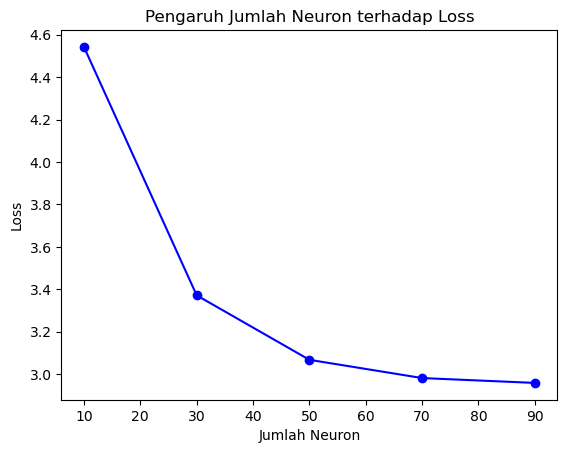

In [27]:
# Plot pengaruh jumlah neuron terhadap loss
plt.plot(neuron_range, losses1N_val, 'bo-')
plt.xlabel('Jumlah Neuron')
plt.ylabel('Loss')
plt.title('Pengaruh Jumlah Neuron terhadap Loss')
plt.show()

In [43]:
# Rentang jumlah neuron yang ingin dieksplorasi
neuron_range = range(85, 101)

# List untuk menyimpan loss
losses1N_val_2 = []
losses1N_2 = []

# Membuat dan melatih model untuk setiap jumlah neuron
for num_neurons in neuron_range:
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train1.shape[1], activation='selu'))
    model.add(Dense(y_train1.shape[1], activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    history1N = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, batch_size=16)
    loss1N_val = history1N.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
    loss1N = history1N.history['loss'][-1]  # Mengambil loss pada epoch terakhir
    losses1N_val_2.append(loss1N_val)
    losses1N_2.append(loss1N)

np.save('losses1N_val_All1_rev.npy', losses1N_val_2)
np.save('losses1N_All1_rev.npy', losses1N_2)


Epoch 1/1000
34/34 [==============================] - 1s 8ms/step - loss: 25.6535 - val_loss: 24.9339
Epoch 2/1000
34/34 [==============================] - 0s 3ms/step - loss: 24.8286 - val_loss: 24.0167
Epoch 3/1000
34/34 [==============================] - 0s 3ms/step - loss: 23.7123 - val_loss: 22.8042
Epoch 4/1000
34/34 [==============================] - 0s 3ms/step - loss: 22.2283 - val_loss: 21.2315
Epoch 5/1000
34/34 [==============================] - 0s 3ms/step - loss: 20.3773 - val_loss: 19.3686
Epoch 6/1000
34/34 [==============================] - 0s 3ms/step - loss: 18.1657 - val_loss: 17.1083
Epoch 7/1000
34/34 [==============================] - 0s 3ms/step - loss: 15.6920 - val_loss: 14.8587
Epoch 8/1000
34/34 [==============================] - 0s 3ms/step - loss: 13.8550 - val_loss: 13.6806
Epoch 9/1000
34/34 [==============================] - 0s 3ms/step - loss: 13.0050 - val_loss: 13.0158
Epoch 10/1000
34/34 [==============================] - 0s 3ms/step - loss: 12.4197

34/34 [==============================] - 0s 3ms/step - loss: 5.0321 - val_loss: 5.2825
Epoch 162/1000
34/34 [==============================] - 0s 3ms/step - loss: 5.0269 - val_loss: 5.2751
Epoch 163/1000
34/34 [==============================] - 0s 3ms/step - loss: 5.0184 - val_loss: 5.2686
Epoch 164/1000
34/34 [==============================] - 0s 2ms/step - loss: 5.0011 - val_loss: 5.2602
Epoch 165/1000
34/34 [==============================] - 0s 3ms/step - loss: 4.9973 - val_loss: 5.2410
Epoch 166/1000
34/34 [==============================] - 0s 2ms/step - loss: 4.9845 - val_loss: 5.2400
Epoch 167/1000
34/34 [==============================] - 0s 3ms/step - loss: 4.9772 - val_loss: 5.2321
Epoch 168/1000
34/34 [==============================] - 0s 3ms/step - loss: 4.9712 - val_loss: 5.2338
Epoch 169/1000
34/34 [==============================] - 0s 2ms/step - loss: 4.9630 - val_loss: 5.2049
Epoch 170/1000
34/34 [==============================] - 0s 2ms/step - loss: 4.9496 - val_loss: 5.

34/34 [==============================] - 0s 3ms/step - loss: 3.9606 - val_loss: 4.1879
Epoch 322/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.9504 - val_loss: 4.1730
Epoch 323/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.9542 - val_loss: 4.1760
Epoch 324/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.9529 - val_loss: 4.1726
Epoch 325/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.9416 - val_loss: 4.1675
Epoch 326/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.9398 - val_loss: 4.1723
Epoch 327/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.9400 - val_loss: 4.1543
Epoch 328/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.9305 - val_loss: 4.1644
Epoch 329/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.9220 - val_loss: 4.1554
Epoch 330/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.9226 - val_loss: 4.

34/34 [==============================] - 0s 3ms/step - loss: 3.4542 - val_loss: 3.7208
Epoch 482/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.4515 - val_loss: 3.7305
Epoch 483/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.4475 - val_loss: 3.7291
Epoch 484/1000
34/34 [==============================] - 0s 2ms/step - loss: 3.4439 - val_loss: 3.7148
Epoch 485/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.4528 - val_loss: 3.7101
Epoch 486/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.4393 - val_loss: 3.7096
Epoch 487/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.4374 - val_loss: 3.7080
Epoch 488/1000
34/34 [==============================] - 0s 2ms/step - loss: 3.4338 - val_loss: 3.7154
Epoch 489/1000
34/34 [==============================] - 0s 2ms/step - loss: 3.4293 - val_loss: 3.6960
Epoch 490/1000
34/34 [==============================] - 0s 2ms/step - loss: 3.4400 - val_loss: 3.

34/34 [==============================] - 0s 2ms/step - loss: 3.1226 - val_loss: 3.4370
Epoch 642/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.1337 - val_loss: 3.4049
Epoch 643/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.1185 - val_loss: 3.4038
Epoch 644/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.1116 - val_loss: 3.4064
Epoch 645/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.1084 - val_loss: 3.3956
Epoch 646/1000
34/34 [==============================] - 0s 2ms/step - loss: 3.1154 - val_loss: 3.3907
Epoch 647/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.1107 - val_loss: 3.4016
Epoch 648/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.1128 - val_loss: 3.3929
Epoch 649/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.1077 - val_loss: 3.3989
Epoch 650/1000
34/34 [==============================] - 0s 2ms/step - loss: 3.1105 - val_loss: 3.

34/34 [==============================] - 0s 3ms/step - loss: 2.9000 - val_loss: 3.1686
Epoch 802/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.9066 - val_loss: 3.1569
Epoch 803/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.8951 - val_loss: 3.1868
Epoch 804/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.8949 - val_loss: 3.1709
Epoch 805/1000
34/34 [==============================] - 0s 2ms/step - loss: 2.8966 - val_loss: 3.1613
Epoch 806/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.9000 - val_loss: 3.1625
Epoch 807/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.8874 - val_loss: 3.1901
Epoch 808/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.8971 - val_loss: 3.1581
Epoch 809/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.8849 - val_loss: 3.1667
Epoch 810/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.8992 - val_loss: 3.

34/34 [==============================] - 0s 3ms/step - loss: 2.7082 - val_loss: 2.9658
Epoch 962/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.7029 - val_loss: 2.9753
Epoch 963/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.7042 - val_loss: 2.9782
Epoch 964/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.7079 - val_loss: 2.9531
Epoch 965/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.7025 - val_loss: 2.9616
Epoch 966/1000
34/34 [==============================] - 0s 2ms/step - loss: 2.7024 - val_loss: 2.9456
Epoch 967/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.7051 - val_loss: 2.9396
Epoch 968/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.7035 - val_loss: 2.9314
Epoch 969/1000
34/34 [==============================] - 0s 3ms/step - loss: 2.6935 - val_loss: 2.9467
Epoch 970/1000
34/34 [==============================] - 0s 2ms/step - loss: 2.7047 - val_loss: 2.

34/34 [==============================] - 0s 3ms/step - loss: 5.3932 - val_loss: 5.6689
Epoch 123/1000
34/34 [==============================] - 0s 3ms/step - loss: 5.3786 - val_loss: 5.6518
Epoch 124/1000
34/34 [==============================] - 0s 3ms/step - loss: 5.3661 - val_loss: 5.6408
Epoch 125/1000
34/34 [==============================] - 0s 3ms/step - loss: 5.3505 - val_loss: 5.6212
Epoch 126/1000
34/34 [==============================] - 0s 2ms/step - loss: 5.3413 - val_loss: 5.6095
Epoch 127/1000
34/34 [==============================] - 0s 3ms/step - loss: 5.3264 - val_loss: 5.6001
Epoch 128/1000
34/34 [==============================] - 0s 3ms/step - loss: 5.3095 - val_loss: 5.5858
Epoch 129/1000
34/34 [==============================] - 0s 3ms/step - loss: 5.3133 - val_loss: 5.5821
Epoch 130/1000
34/34 [==============================] - 0s 3ms/step - loss: 5.2898 - val_loss: 5.5573
Epoch 131/1000
34/34 [==============================] - 0s 3ms/step - loss: 5.2762 - val_loss: 5.

34/34 [==============================] - 0s 3ms/step - loss: 4.1174 - val_loss: 4.3595
Epoch 283/1000
34/34 [==============================] - 0s 3ms/step - loss: 4.1085 - val_loss: 4.3781
Epoch 284/1000
34/34 [==============================] - 0s 2ms/step - loss: 4.1027 - val_loss: 4.3601
Epoch 285/1000
34/34 [==============================] - 0s 3ms/step - loss: 4.1030 - val_loss: 4.3537
Epoch 286/1000
34/34 [==============================] - 0s 2ms/step - loss: 4.0956 - val_loss: 4.3430
Epoch 287/1000
34/34 [==============================] - 0s 3ms/step - loss: 4.0892 - val_loss: 4.3417
Epoch 288/1000
34/34 [==============================] - 0s 3ms/step - loss: 4.0812 - val_loss: 4.3284
Epoch 289/1000
34/34 [==============================] - 0s 3ms/step - loss: 4.0804 - val_loss: 4.3212
Epoch 290/1000
34/34 [==============================] - 0s 3ms/step - loss: 4.0779 - val_loss: 4.3352
Epoch 291/1000
34/34 [==============================] - 0s 3ms/step - loss: 4.0719 - val_loss: 4.

34/34 [==============================] - 0s 3ms/step - loss: 3.5606 - val_loss: 3.9127
Epoch 443/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.5672 - val_loss: 3.9141
Epoch 444/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.5686 - val_loss: 3.9035
Epoch 445/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.5571 - val_loss: 3.9063
Epoch 446/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.5587 - val_loss: 3.8968
Epoch 447/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.5515 - val_loss: 3.8983
Epoch 448/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.5509 - val_loss: 3.8963
Epoch 449/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.5454 - val_loss: 3.8973
Epoch 450/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.5412 - val_loss: 3.9074
Epoch 451/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.5476 - val_loss: 3.

34/34 [==============================] - 0s 2ms/step - loss: 3.2469 - val_loss: 3.6077
Epoch 603/1000
34/34 [==============================] - 0s 2ms/step - loss: 3.2488 - val_loss: 3.5951
Epoch 604/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.2433 - val_loss: 3.6329
Epoch 605/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.2483 - val_loss: 3.6173
Epoch 606/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.2531 - val_loss: 3.6387
Epoch 607/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.2416 - val_loss: 3.6249
Epoch 608/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.2394 - val_loss: 3.5977
Epoch 609/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.2358 - val_loss: 3.5936
Epoch 610/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.2352 - val_loss: 3.6164
Epoch 611/1000
34/34 [==============================] - 0s 3ms/step - loss: 3.2310 - val_loss: 3.

KeyboardInterrupt: 

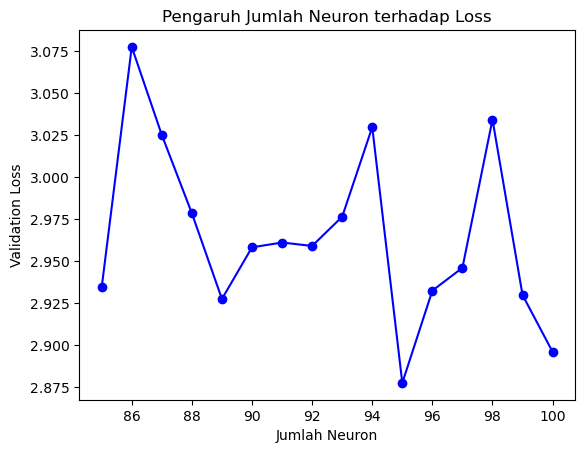

In [29]:
# Plot pengaruh jumlah neuron terhadap loss
plt.plot(neuron_range, losses1N_val_2, 'bo-')
plt.xlabel('Jumlah Neuron')
plt.ylabel('Validation Loss')
plt.title('Pengaruh Jumlah Neuron terhadap Loss')
plt.show()

#### Mencari fungsi aktivasi dan optimizer yang optimal
Jumlah fungsi aktivasi dan optimizer yang akan dieksplorasi yaitu masing-masing berjumlah 8, sehingga akan ada 64 model ANN yang akan dibandingkan hasil Lossnya dan yang terkecil nilai Lossnya akan digunakan pada tahap selanjutnya.

In [ ]:
# Kumpulan activation function yang ingin dieksplorasi
activation_functions = ['relu', 'sigmoid', 'tanh', 'softplus', 'softsign', 'selu', 'elu', 'exponential']
# Kumpulan optimizer yang ingin dieksplorasi
optimizers = ['adam', 'rmsprop', 'sgd', 'adadelta', 'adagrad', 'adamax', 'nadam', 'ftrl']

# List untuk menyimpan loss
losses1AO_val = []
losses1AO = []

# Membuat dan melatih model untuk setiap activation function
for activation_func in activation_functions:
    for optimizer in optimizers:
        np.random.seed(42)
        random.seed(42)
        tf.random.set_seed(42)    
        model = Sequential()
        model.add(Dense(95, input_dim=X_train1.shape[1], activation=activation_func))
        model.add(Dense(y_train1.shape[1], activation='linear'))
        model.compile(loss='mean_absolute_error', optimizer=optimizer)
        history1AO = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, batch_size=16)
        loss1AO_val = history1AO.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
        loss1AO = history1AO.history['loss'][-1]
        losses1AO.append(loss1AO)
        losses1AO_val.append(loss1AO_val)
        print(activation_func)
        print(optimizer)

In [31]:
np.save('losses1AO_All_rev.npy', losses1AO)
np.save('losses1AO_val_All_rev.npy', losses1AO_val)

# memanggil gunakan 'np.load()'

In [4]:
losses1AO_val = np.load('losses1AO_val_All_rev.npy')

In [5]:
activation_functions = ['relu', 'sigmoid', 'tanh', 'softplus', 'softsign', 'selu', 'elu', 'exponential']
# Memisahkan data menjadi 8 bagian
relu = losses1AO_val[:8]
sigmoid = losses1AO_val[8:16]
tanh = losses1AO_val[16:24]
softplus = losses1AO_val[24:32]
softsign = losses1AO_val[32:40]
selu = losses1AO_val[40:48]
elu = losses1AO_val[48:56]
exponential = losses1AO_val[56:]

In [6]:
# Membuat DataFrame menggunakan pandas
dfAO = pd.DataFrame({'relu': relu, 'sigmoid': sigmoid, 'tanh': tanh, 'softplus': softplus, 'softsign': softsign, 'selu': selu, 'elu': elu, 'exponential': exponential})

dfAO.index = ['adam', 'rmsprop', 'sgd', 'adadelta', 'adagrad', 'adamax', 'nadam', 'ftrl']

# Menampilkan tabel
print(dfAO)

               relu    sigmoid       tanh   softplus   softsign       selu  \
adam       3.007827   2.719781   1.595781   4.149133   1.748053   2.877653   
rmsprop    3.145210   2.762928   1.625719   4.337265   1.746249   3.035598   
sgd        3.382434   5.763658   2.720325   4.698755   3.262367   3.327717   
adadelta  24.441620  21.109209  23.664650  20.355848  24.109934  23.062868   
adagrad   13.377854  17.227455  14.494986  13.986542  16.705648  12.538360   
adamax     4.778760   4.445496   2.733108   6.300914   3.128531   4.096085   
nadam      3.075742   2.704835   1.597373   4.157113   1.748039   2.877331   
ftrl      14.196859  17.170763  14.976776  14.367417  17.307970  13.487394   

                elu  exponential  
adam       3.004473     3.214420  
rmsprop    3.073981     3.475424  
sgd        3.849653     2.404838  
adadelta  23.644318    19.202444  
adagrad   13.166224    13.358994  
adamax     4.264718     4.594563  
nadam      3.020828     3.166387  
ftrl      13.7945

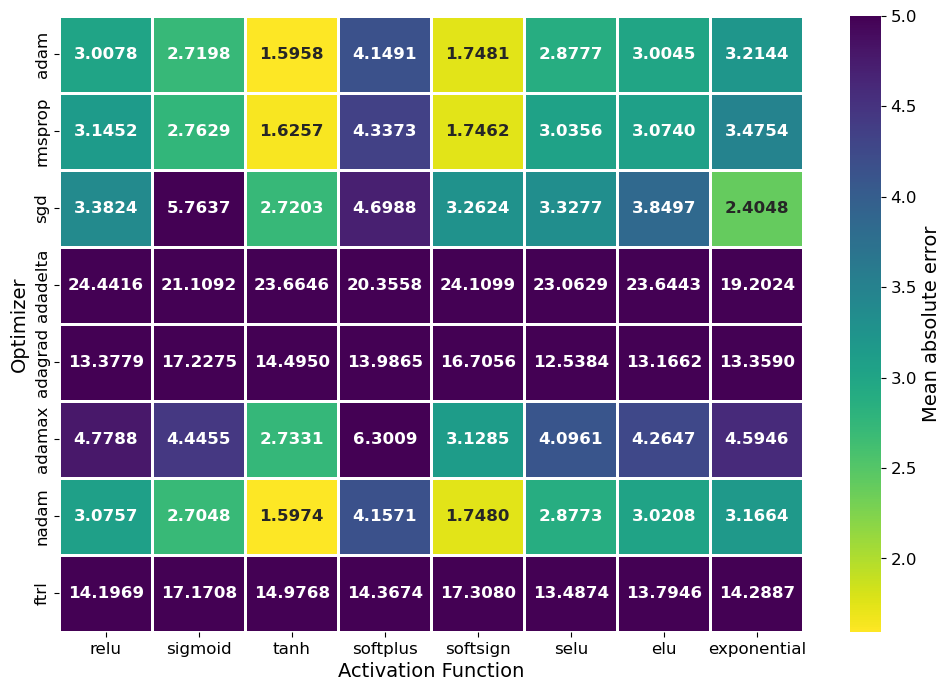

In [16]:
import seaborn as sns

# Membuat plot heatmap menggunakan seaborn
plt.figure(figsize=(12,8))
ax = sns.heatmap(dfAO, cmap='viridis_r', vmin=1.595, vmax=5, linewidths=1, annot=True, fmt=".4f", annot_kws={"size": 12, "weight": "bold"})
# Mengatur label pada sumbu x dan sumbu y
ax.set_xlabel('Activation Function', fontsize=14)
ax.set_ylabel('Optimizer', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# Menambahkan color bar
cbar = ax.collections[0].colorbar
cbar.set_label('Mean absolute error', fontsize=14)  # Ganti 'Label Color Bar' dengan label yang sesuai
cbar.ax.tick_params(labelsize=12)

# Menampilkan plot
plt.show()

In [ ]:
# Rentang jumlah neuron yang ingin dieksplorasi
neuron_range = range(90, 101)

# List untuk menyimpan loss
losses1N_val_2 = []
losses1N_2 = []

# Membuat dan melatih model untuk setiap jumlah neuron
for num_neurons in neuron_range:
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train1.shape[1], activation='tanh'))
    model.add(Dense(y_train1.shape[1], activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    history1N = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, batch_size=16)
    loss1N_val = history1N.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
    loss1N = history1N.history['loss'][-1]  # Mengambil loss pada epoch terakhir
    losses1N_val_2.append(loss1N_val)
    losses1N_2.append(loss1N)

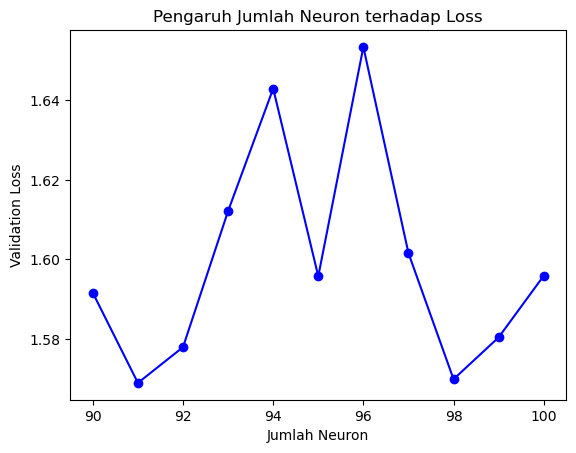

In [37]:
# Plot pengaruh jumlah neuron terhadap loss
plt.plot(neuron_range, losses1N_val_2, 'bo-')
plt.xlabel('Number of Neuron')
plt.ylabel('Mean absolute error \nof validation data')
plt.title('Pengaruh Jumlah Neuron terhadap Loss')
plt.show()

In [ ]:
# Plot pengaruh jumlah neuron terhadap loss
plt.plot(neuron_range, losses1N_val_2, 'bo-')
plt.xlabel('Number of Neuron')
plt.ylabel('Mean absolute error \n of validation data')
plt.title('Influence of the number of neurons on loss')
plt.show()

In [38]:
losses1N_val_2

[1.5916249752044678,
 1.5689960718154907,
 1.5779836177825928,
 1.6121697425842285,
 1.6429238319396973,
 1.595780849456787,
 1.6533923149108887,
 1.6015912294387817,
 1.5699272155761719,
 1.580435872077942,
 1.595920205116272]

#### Mencari jumlah hidden layer yang optimal
Pada tahap ini, akan dicari jumlah hidden layer yang optimal dengan secara bertahap menambahkan jumlah hidden layer dengan jumlah neuron yang sama pada masing-masing layer.

In [ ]:
# Rentang jumlah layer yang ingin dieksplorasi
layer_range = range(1, 7)

# List untuk menyimpan loss
losses1HL = []
losses1HL_val = []

# Membuat dan melatih model untuk setiap jumlah layer
for num_layers in layer_range:
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)    
    model = Sequential()
    model.add(Dense(91, input_dim=X_train1.shape[1], activation='tanh'))
    for _ in range(num_layers-1):
        model.add(Dense(91, activation='tanh'))
    model.add(Dense(y_train1.shape[1], activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    history1L = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, batch_size=16)
    loss1HL = history1L.history['loss'][-1]  # Mengambil loss pada epoch terakhir
    loss1HL_val = history1L.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
    losses1HL.append(loss1HL)
    losses1HL_val.append(loss1HL_val)
    print(num_layers)

np.save('losses1HL_val_All_rev.npy', losses1HL_val)
np.save('losses1HL_All_rev.npy', losses1HL)

In [40]:
losses1HL_val

[1.5689960718154907,
 1.013701319694519,
 0.9404977560043335,
 0.8626856207847595,
 0.951367199420929,
 1.052645206451416]

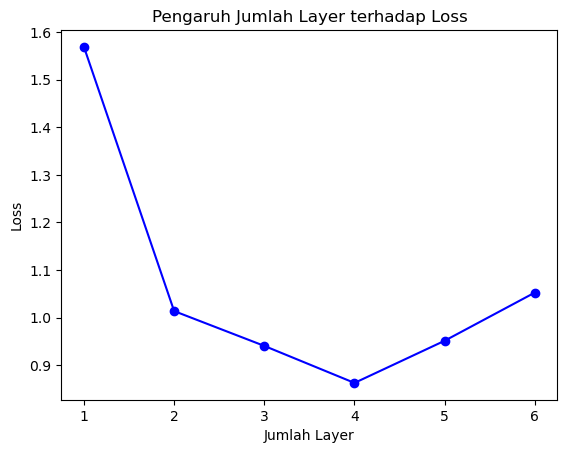

In [41]:
# Plot pengaruh jumlah layer terhadap loss
plt.plot(layer_range, losses1HL_val, 'bo-')
plt.xlabel('Jumlah Layer')
plt.ylabel('Loss')
plt.title('Pengaruh Jumlah Layer terhadap Loss')
plt.show()

#### Mencari kombinasi jumlah neuron untuk hidden layer 2 dan 3 yang optimal

In [ ]:
# Rentang jumlah neuron yang ingin dieksplorasi
#neuron_range = range(91, 96)
neuron_range2 = [92]
neuron range3 = [91]
neuron_range4 = range(96, 101)

# List untuk menyimpan loss
losses1NHL_val = []
losses1NHL = []

# Membuat dan melatih model untuk setiap jumlah neuron
for num_neurons2 in neuron_range:
    for num_neurons3 in neuron_range:
        for num_neurons4 in neuron_range:
            np.random.seed(42)
            random.seed(42)
            tf.random.set_seed(42)
            model = Sequential()
            model.add(Dense(91, input_dim=X_train1.shape[1], activation='tanh'))
            model.add(Dense(num_neurons2, activation='tanh'))
            model.add(Dense(num_neurons3, activation='tanh'))        
            model.add(Dense(num_neurons4, activation='tanh'))        
            model.add(Dense(y_train1.shape[1], activation='linear'))
            model.compile(loss='mean_absolute_error', optimizer='adam')
            history = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, batch_size=16)
            loss_val = history.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
            loss = history.history['loss']
            losses1NHL_val.append(loss_val)
            losses1NHL.append(loss)

np.save('losses1NHL_val_All_rev.npy', losses1NHL_val)
np.save('losses1NHL_All_rev.npy', losses1NHL)

In [ ]:
# Plot pengaruh jumlah neuron terhadap loss
neuron2_3_4 = ['91_91_91','91_91_92','91_91_93','91_91_94','91_91_95',
             '91_92_91','91_92_92','91_92_93','91_92_94','91_92_95',
             '91_93_91','91_93_92','91_93_93','93_91_94','91_93_95',
             '91_94_91','91_94_92','91_94_93','91_94_94','91_94_95',
             '91_95_91','95_91_92','91_95_93','91_95_94','91_95_95',
             '92_91_91','92_91_92','92_91_93','92_91_94','92_91_95',
             '92_92_91','91_92_92','91_92_93','91_92_94','91_92_95',
             '92_93_91','91_93_92','91_93_93','93_91_94','91_93_95',
             '92_94_91','91_94_92','91_94_93','91_94_94','91_94_95',
             '92_95_91','95_91_92','91_95_93','91_95_94','91_95_95',
             '93_91_91','91_91_92','91_91_93','91_91_94','91_91_95',
             '93_92_91','91_92_92','91_92_93','91_92_94','91_92_95',
             '93_93_91','91_93_92','91_93_93','93_91_94','91_93_95',
             '93_94_91','91_94_92','91_94_93','91_94_94','91_94_95',
             '93_95_91','95_91_92','91_95_93','91_95_94','91_95_95',
             '94_91_91','91_91_92','91_91_93','91_91_94','91_91_95',
             '94_92_91','91_92_92','91_92_93','91_92_94','91_92_95',
             '94_93_91','91_93_92','91_93_93','93_91_94','91_93_95',
             '94_94_91','91_94_92','91_94_93','91_94_94','91_94_95',
             '94_95_91','95_91_92','91_95_93','91_95_94','91_95_95',
             '95_91_91','91_91_92','91_91_93','91_91_94','91_91_95',
             '95_92_91','91_92_92','91_92_93','91_92_94','91_92_95',
             '95_93_91','91_93_92','91_93_93','93_91_94','91_93_95',
             '95_94_91','91_94_92','91_94_93','91_94_94','91_94_95',
             '95_95_91','95_91_92','91_95_93','91_95_94','91_95_95']
plt.figure(figsize=(12, 8))
plt.plot(neuron2_3_4, losses1NHL_val, 'bo-')
# Mengatur rotasi xlabel
plt.xticks(rotation=90)
plt.xlabel('Variasi layer 2, 3, dan layer 4')
plt.ylabel('Validation Loss')
plt.title('Pengaruh Variasi layer 2, 3, dan layer 4 terhadap Loss')
plt.show()

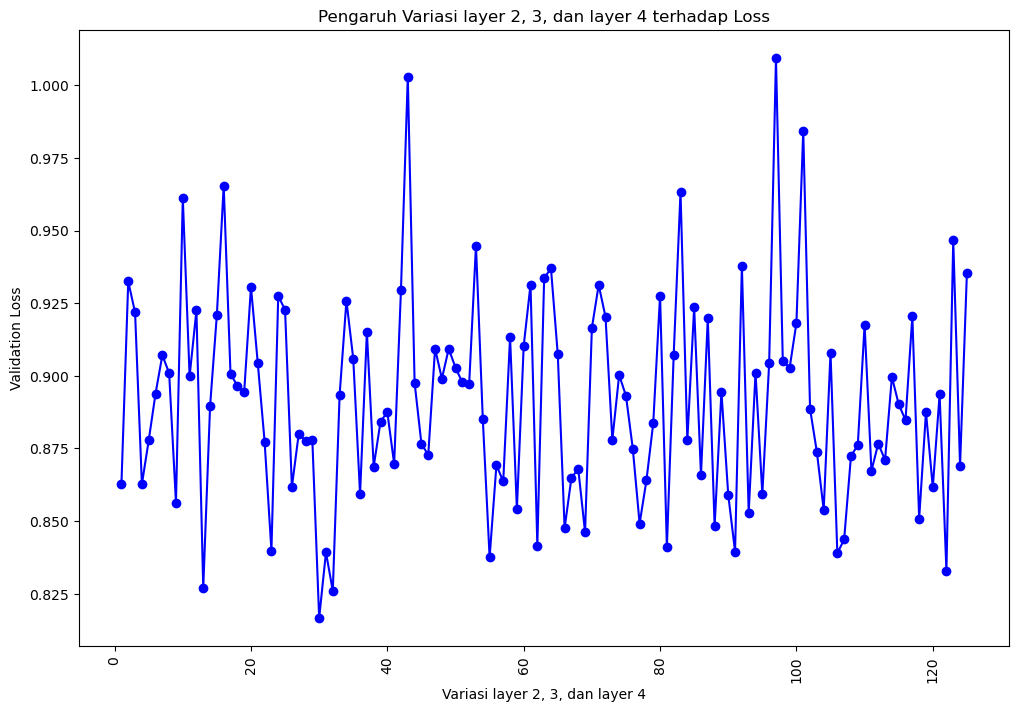

In [47]:
# Plot pengaruh jumlah neuron terhadap loss
neuron2_3_4 = range(1,126)
plt.figure(figsize=(12, 8))
plt.plot(neuron2_3_4, losses1NHL_val, 'bo-')
# Mengatur rotasi xlabel
plt.xticks(rotation=90)
plt.xlabel('Variasi layer 2, 3, dan layer 4')
plt.ylabel('Validation Loss')
plt.title('Pengaruh Variasi layer 2, 3, dan layer 4 terhadap Loss')
plt.show()

In [46]:
losses1NHL_val

[0.8626856207847595,
 0.9324727058410645,
 0.9218477606773376,
 0.8626940846443176,
 0.8777537941932678,
 0.8938322067260742,
 0.9070962071418762,
 0.9009467363357544,
 0.8563756942749023,
 0.961209237575531,
 0.8998721241950989,
 0.9225102663040161,
 0.8270964622497559,
 0.8894887566566467,
 0.9210723638534546,
 0.9654653072357178,
 0.9006407260894775,
 0.8966466188430786,
 0.8942766785621643,
 0.9306614398956299,
 0.9043041467666626,
 0.8773633241653442,
 0.8398662805557251,
 0.9275078773498535,
 0.9226987361907959,
 0.86174476146698,
 0.8799634575843811,
 0.8777341842651367,
 0.8780025839805603,
 0.8166291117668152,
 0.839262843132019,
 0.8259746432304382,
 0.8933442831039429,
 0.925906240940094,
 0.9059322476387024,
 0.8592724204063416,
 0.9150788187980652,
 0.868797242641449,
 0.8842299580574036,
 0.8874939680099487,
 0.8697110414505005,
 0.9296699166297913,
 1.0028856992721558,
 0.8976195454597473,
 0.8766142725944519,
 0.8727648854255676,
 0.9093900918960571,
 0.899027407169342,

#### Mencari Epoch dan Batch size yang optimal

In [ ]:
# Variasi untuk jumlah epochs
epochs_values = [1000, 2000, 4000]
# Variasi untuk ukuran batch (batch_size)
batch_sizes = [16, 32, 64]
# List untuk menyimpan loss
losses1EB = []
losses1EB_val = []

for epochs in epochs_values:
    for batch_size in batch_sizes:
        np.random.seed(42)
        random.seed(42)
        tf.random.set_seed(42)
        model = Sequential()
        model.add(Dense(91, input_dim=X_train1.shape[1], activation='tanh'))
        model.add(Dense(92, activation='tanh'))
        model.add(Dense(91, activation='tanh'))
        model.add(Dense(95, activation='tanh'))
        model.add(Dense(y_train1.shape[1], activation='linear'))
        model.compile(loss='mean_absolute_error', optimizer='adam')
    
        start_time = time.time()
        history = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=epochs, batch_size=batch_size)
        end_time = time.time()
        loss_e = history.history['loss'][-1]
        loss_e_val = history.history['val_loss'][-1]
        losses1EB.append(loss_e)
        losses1EB_val.append(loss_e_val)
  #  print(f"Training with {epochs} epochs took {end_time - start_time} seconds. Final loss: {loss[-1]}")
np.save('losses1EB_val_All_rev.npy', losses1EB_val)
np.save('losses1EB_All_rev.npy', losses1EB)

In [17]:
losses1EB_val = np.load('losses1EB_val_All_rev.npy')

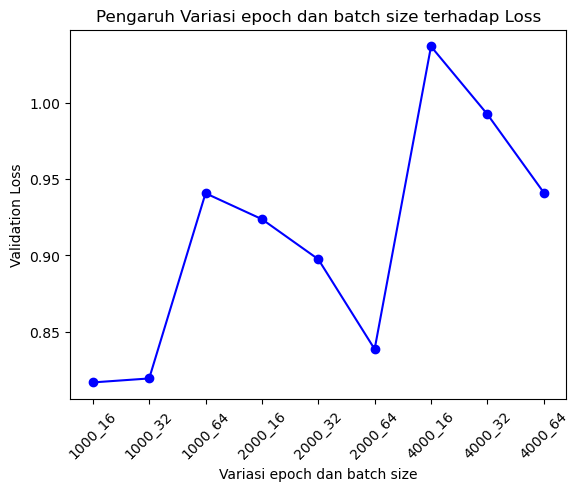

In [18]:
# Plot pengaruh jumlah neuron terhadap loss
epoch_batch = ['1000_16','1000_32','1000_64',
               '2000_16','2000_32','2000_64',
               '4000_16','4000_32','4000_64']
#plt.figure(figsize=(12, 8))
plt.plot(epoch_batch, losses1EB_val, 'bo-')
plt.xticks(rotation=45)
plt.xlabel('Variasi epoch dan batch size')
plt.ylabel('Validation Loss')
plt.title('Pengaruh Variasi epoch dan batch size terhadap Loss')
plt.show()

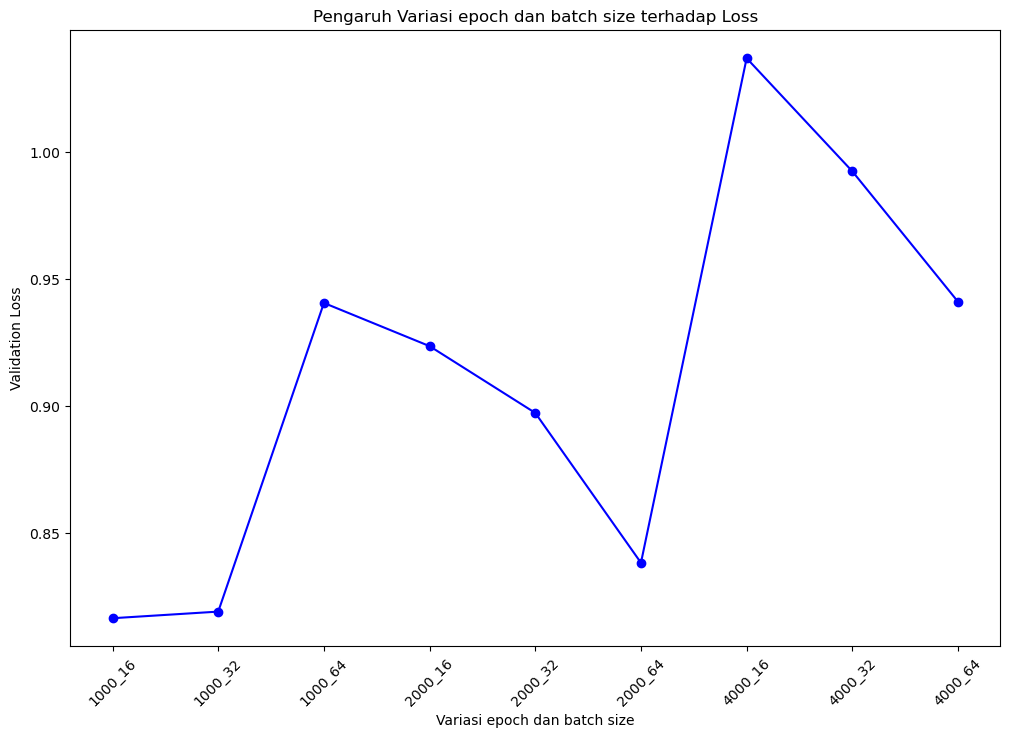

In [52]:
# Plot pengaruh jumlah neuron terhadap loss
epoch_batch = ['1000_16','1000_32','1000_64',
               '2000_16','2000_32','2000_64',
               '4000_16','4000_32','4000_64']
plt.figure(figsize=(12, 8))
plt.plot(epoch_batch, losses1EB_val, 'bo-')
plt.xticks(rotation=45)
plt.xlabel('Variasi epoch dan batch size')
plt.ylabel('Validation Loss')
plt.title('Pengaruh Variasi epoch dan batch size terhadap Loss')
plt.show()

In [53]:
losses1EB_val

[0.8166291117668152,
 0.8192303776741028,
 0.9407160878181458,
 0.9237157106399536,
 0.8974288702011108,
 0.8384535908699036,
 1.0370397567749023,
 0.9925253391265869,
 0.9411922693252563]

#### Epoch yang paling optimal

In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

losses1_val=[]
losses1=[]

model = Sequential()
model.add(Dense(91, input_dim=X_train1.shape[1], activation='tanh'))
model.add(Dense(92, activation='tanh'))
model.add(Dense(91, activation='tanh'))
model.add(Dense(95, activation='tanh'))
model.add(Dense(y_train1.shape[1], activation='linear'))
model.compile(loss='mean_absolute_error', optimizer='adam')
    
start_time = time.time()
history = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=1000, batch_size=16)
end_time = time.time()
loss = history.history['loss'][-1]
loss_val = history.history['val_loss'][-1]
losses1.append(loss)
losses1_val.append(loss_val)

In [55]:
# Mencari index epoch dengan val_loss minimum
min_val_loss_epoch = np.argmin(history.history['val_loss']) + 1  # +1 karena indeks dimulai dari 0

# Menyimpan val_loss minimum
min_val_loss = history.history['val_loss'][min_val_loss_epoch - 1]

print(f"Epoch dengan val_loss minimum: {min_val_loss_epoch}")
print(f"Nilai val_loss minimum: {min_val_loss}")

Epoch dengan val_loss minimum: 903
Nilai val_loss minimum: 0.8165664672851562


### ANN model 1

In [56]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

losses1_val=[]
losses1=[]

model = Sequential()
model.add(Dense(91, input_dim=X_train1.shape[1], activation='tanh'))
model.add(Dense(92, activation='tanh'))
model.add(Dense(91, activation='tanh'))
model.add(Dense(95, activation='tanh'))
model.add(Dense(y_train1.shape[1], activation='linear'))
model.compile(loss='mean_absolute_error', optimizer='adam')
    
start_time = time.time()
history = model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=903, batch_size=16)
end_time = time.time()
loss = history.history['loss'][-1]
loss_val = history.history['val_loss'][-1]
losses1.append(loss)
losses1_val.append(loss_val)

Epoch 1/903
34/34 [==============================] - 1s 9ms/step - loss: 23.5006 - val_loss: 21.0789
Epoch 2/903
34/34 [==============================] - 0s 3ms/step - loss: 19.7265 - val_loss: 19.0275
Epoch 3/903
34/34 [==============================] - 0s 3ms/step - loss: 18.0187 - val_loss: 17.6731
Epoch 4/903
34/34 [==============================] - 0s 3ms/step - loss: 16.7365 - val_loss: 16.4675
Epoch 5/903
34/34 [==============================] - 0s 3ms/step - loss: 15.4682 - val_loss: 15.2999
Epoch 6/903
34/34 [==============================] - 0s 3ms/step - loss: 14.3457 - val_loss: 14.1943
Epoch 7/903
34/34 [==============================] - 0s 3ms/step - loss: 13.3857 - val_loss: 13.4407
Epoch 8/903
34/34 [==============================] - 0s 3ms/step - loss: 12.6391 - val_loss: 12.6647
Epoch 9/903
34/34 [==============================] - 0s 3ms/step - loss: 11.8906 - val_loss: 12.0266
Epoch 10/903
34/34 [==============================] - 0s 4ms/step - loss: 11.1702 - val_los

Epoch 83/903
34/34 [==============================] - 0s 3ms/step - loss: 1.1271 - val_loss: 1.2601
Epoch 84/903
34/34 [==============================] - 0s 3ms/step - loss: 1.0959 - val_loss: 1.3547
Epoch 85/903
34/34 [==============================] - 0s 3ms/step - loss: 1.1221 - val_loss: 1.4539
Epoch 86/903
34/34 [==============================] - 0s 3ms/step - loss: 1.0280 - val_loss: 1.3436
Epoch 87/903
34/34 [==============================] - 0s 3ms/step - loss: 1.0191 - val_loss: 1.2844
Epoch 88/903
34/34 [==============================] - 0s 4ms/step - loss: 1.0285 - val_loss: 1.2725
Epoch 89/903
34/34 [==============================] - 0s 3ms/step - loss: 1.0448 - val_loss: 1.3412
Epoch 90/903
34/34 [==============================] - 0s 3ms/step - loss: 1.0725 - val_loss: 1.3963
Epoch 91/903
34/34 [==============================] - 0s 3ms/step - loss: 1.1187 - val_loss: 1.3390
Epoch 92/903
34/34 [==============================] - 0s 3ms/step - loss: 1.0496 - val_loss: 1.4594


34/34 [==============================] - 0s 3ms/step - loss: 0.8033 - val_loss: 1.0554
Epoch 246/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7932 - val_loss: 1.0286
Epoch 247/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7678 - val_loss: 1.0437
Epoch 248/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7565 - val_loss: 1.0710
Epoch 249/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7727 - val_loss: 1.1350
Epoch 250/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7813 - val_loss: 1.0304
Epoch 251/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7630 - val_loss: 1.1458
Epoch 252/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7921 - val_loss: 1.0203
Epoch 253/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7635 - val_loss: 1.0731
Epoch 254/903
34/34 [==============================] - 0s 3ms/step - loss: 0.8117 - val_loss: 1.2290
Epoc

34/34 [==============================] - 0s 3ms/step - loss: 0.6955 - val_loss: 1.0067
Epoch 408/903
34/34 [==============================] - 0s 3ms/step - loss: 0.6894 - val_loss: 0.9411
Epoch 409/903
34/34 [==============================] - 0s 5ms/step - loss: 0.6893 - val_loss: 1.0244
Epoch 410/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7316 - val_loss: 1.0271
Epoch 411/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7168 - val_loss: 1.1079
Epoch 412/903
34/34 [==============================] - 0s 4ms/step - loss: 0.7307 - val_loss: 1.0225
Epoch 413/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7045 - val_loss: 1.0400
Epoch 414/903
34/34 [==============================] - 0s 4ms/step - loss: 0.6856 - val_loss: 0.9924
Epoch 415/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7274 - val_loss: 1.1230
Epoch 416/903
34/34 [==============================] - 0s 3ms/step - loss: 0.7286 - val_loss: 1.0814
Epoc

34/34 [==============================] - 0s 3ms/step - loss: 0.6465 - val_loss: 0.9050
Epoch 570/903
34/34 [==============================] - 0s 4ms/step - loss: 0.6101 - val_loss: 1.0920
Epoch 571/903
34/34 [==============================] - 0s 3ms/step - loss: 0.6030 - val_loss: 0.9280
Epoch 572/903
34/34 [==============================] - 0s 3ms/step - loss: 0.6030 - val_loss: 1.0539
Epoch 573/903
34/34 [==============================] - 0s 3ms/step - loss: 0.6093 - val_loss: 0.9177
Epoch 574/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5917 - val_loss: 0.9554
Epoch 575/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5874 - val_loss: 0.8991
Epoch 576/903
34/34 [==============================] - 0s 3ms/step - loss: 0.6033 - val_loss: 1.0034
Epoch 577/903
34/34 [==============================] - 0s 3ms/step - loss: 0.6009 - val_loss: 0.9317
Epoch 578/903
34/34 [==============================] - 0s 3ms/step - loss: 0.6063 - val_loss: 0.9042
Epoc

34/34 [==============================] - 0s 3ms/step - loss: 0.6864 - val_loss: 0.9670
Epoch 732/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5818 - val_loss: 0.8765
Epoch 733/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5824 - val_loss: 0.9941
Epoch 734/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5626 - val_loss: 0.9721
Epoch 735/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5379 - val_loss: 0.9658
Epoch 736/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5313 - val_loss: 0.8855
Epoch 737/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5974 - val_loss: 0.9295
Epoch 738/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5549 - val_loss: 0.8615
Epoch 739/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5252 - val_loss: 0.9104
Epoch 740/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5183 - val_loss: 0.9239
Epoc

34/34 [==============================] - 0s 3ms/step - loss: 0.5406 - val_loss: 0.8824
Epoch 894/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5208 - val_loss: 0.9289
Epoch 895/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5444 - val_loss: 1.0447
Epoch 896/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5611 - val_loss: 0.8623
Epoch 897/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5305 - val_loss: 0.9058
Epoch 898/903
34/34 [==============================] - 0s 3ms/step - loss: 0.4980 - val_loss: 0.8738
Epoch 899/903
34/34 [==============================] - 0s 3ms/step - loss: 0.4888 - val_loss: 0.8633
Epoch 900/903
34/34 [==============================] - 0s 3ms/step - loss: 0.4889 - val_loss: 0.8420
Epoch 901/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5072 - val_loss: 0.8922
Epoch 902/903
34/34 [==============================] - 0s 3ms/step - loss: 0.5308 - val_loss: 0.9234
Epoc

In [57]:
y_val1

V     α     β
396  50.012600  75.0 -15.0
302  10.028600  10.0 -15.0
673  50.036102  -5.0  20.0
541  10.085218   0.0 -10.0
377  30.013600  80.0 -15.0
54   10.029420  65.0   0.0
644  10.045362 -10.0  20.0
257  10.062151  80.0 -10.0
662  40.044166 -25.0  20.0
477  30.040972  80.0 -20.0
55    9.990676  70.0   0.0
638  50.082561  -5.0  10.0
480  40.080216  45.0 -20.0
77   30.056443  80.0   0.0
235  40.026069  25.0 -10.0
277  30.058575  80.0 -10.0
304  10.027444  20.0 -15.0
314  19.993731  20.0 -15.0
90   49.975504  45.0   0.0
456  10.026416  75.0 -20.0
192  50.017131  55.0  -5.0
220  30.192706   0.0 -10.0
547  20.060967  -5.0 -10.0
145  50.020713  25.0  -5.0
164  20.015249  65.0  -5.0
118  20.005021  40.0  -5.0
670  50.061641 -20.0  20.0
518  30.070488 -10.0 -20.0
274  30.024971  65.0 -10.0
447  50.036852  35.0 -20.0
627  40.036833 -25.0  10.0
81   39.970239  50.0   0.0
321  29.976117   5.0 -15.0
558  39.978359 -20.0 -10.0
109  10.035991  45.0  -5.0
284  40.027994  65.0 -10.0
63   20.026379  60.0   0.0
101  10.017451   5.0  -5.0
671  50.048119 -15.0  20.0
76   30.013795  75.0   0.0
583  20.071292   0.0   0.0
10   20.054744   0.0   0.0
593  40.008066 -20.0   0.0
260  19.993375  45.0 -10.0
587  30.057086 -15.0   0.0
259  10.013532  90.0 -10.0
31   40.057814   5.0   0.0
393  50.014066  60.0 -15.0
577  20.046200 -30.0   0.0
353  10.043199  60.0 -15.0
265  19.972679  70.0 -10.0
525  40.008456 -10.0 -20.0
443  50.057390  15.0 -20.0
611  10.059688   0.0  10.0
299  50.019083  90.0 -10.0
468  20.037314  85.0 -20.0
2    10.041767  10.0   0.0
211  20.057624   5.0 -10.0
132  40.022439  10.0  -5.0
575  10.228112  -5.0   0.0
72   30.031068  55.0   0.0
181  39.999026  50.0  -5.0
133  40.051621  15.0  -5.0
398  50.099339  85.0 -15.0
328  30.030175  40.0 -15.0
395  50.002307  70.0 -15.0
78   30.024409  85.0   0.0
234  39.967463  20.0 -10.0
559  39.969992 -15.0 -10.0
120  30.106984   0.0  -5.0
199  50.001867  90.0  -5.0
291  49.983637  50.0 -10.0
60   20.019538  45.0   0.0
663  40.031502 -20.0  20.0
30   40.061003   0.0   0.0
69   20.019834  90.0   0.0
155   9.923403  70.0  -5.0
209   9.994372  45.0 -10.0
44   50.017240  20.0   0.0
70   30.015854  45.0   0.0
481  40.044226  50.0 -20.0
248  50.017486  40.0 -10.0
329  30.018516  45.0 -15.0
421  30.009845   5.0 -20.0
578  20.086983 -25.0   0.0
357  10.065590  80.0 -15.0
182  39.996427  55.0  -5.0
286  39.997658  75.0 -10.0
65   20.014660  70.0   0.0
661  40.052925 -30.0  20.0
49   50.028443  45.0   0.0
158  10.021881  85.0  -5.0
306  10.110996  30.0 -15.0
39   40.025321  45.0   0.0
148  50.018143  40.0  -5.0
399  50.044111  90.0 -15.0
6    10.024660  30.0   0.0
231  40.048304   5.0 -10.0
645  10.078696  -5.0  20.0
213  20.137162  15.0 -10.0
633  50.062506 -30.0  10.0
135  40.014439  25.0  -5.0
335  40.050822  25.0 -15.0
163  20.034442  60.0  -5.0
310  20.069170   0.0 -15.0
86   39.965260  75.0   0.0
176  30.010884  75.0  -5.0
369  20.030076  90.0 -15.0
596  40.100593  -5.0   0.0
628  40.091939 -20.0  10.0
507  20.109356 -30.0 -20.0
165  20.057564  70.0  -5.0
41   50.030691   5.0   0.0
485  40.035536  70.0 -20.0
108  10.025026  40.0  -5.0
408  10.050577  40.0 -20.0
56   10.057256  75.0   0.0
208  10.038158  40.0 -10.0
650  20.051311 -15.0  20.0
646  10.088072   0.0  20.0
136  39.959333  30.0  -5.0
227  29.975361  35.0 -10.0
488  40.062093  85.0 -20.0
131  39.995703   5.0  -5.0
24   30.046396  20.0   0.0
539  10.068628 -10.0 -10.0
533  50.057130  -5.0 -20.0
210  20.065718   0.0 -10.0
604  50.019015   0.0   0.0
110  20.050966   0.0  -5.0
82   40.011134  55.0   0.0
51   10.067544  50.0   0.0
204  10.064146  20.0 -10.0
543  20.081488 -25.0 -10.0
620  30.060250 -25.0  10.0

In [58]:
# Menampilkan MAE & R^2
y_pred1 = model.predict(X_val1)

maeA1 = mean_absolute_error(y_val1['α'], y_pred1[:,1])
maeB1 = mean_absolute_error(y_val1['β'], y_pred1[:,2])
maeS1 = mean_absolute_error(y_val1['V'], y_pred1[:,0])

max_errA1 = max_error(y_val1['α'], y_pred1[:,1])
max_errB1 = max_error(y_val1['β'], y_pred1[:,2])
max_errS1 = max_error(y_val1['V'], y_pred1[:,0])

# Menghitung R^2
r2_AoA1 = r2_score(y_val1['α'], y_pred1[:,1])
r2_AoS1 = r2_score(y_val1['β'], y_pred1[:,2])
r2_Speed1 = r2_score(y_val1['V'], y_pred1[:,0])

print("Mean Absolute Error (MAE) Alpha:", maeA1)
print("Max Error Alpha:", max_errA1)
print("Mean Absolute Error (MAE) Betha:", maeB1)
print("Max Error Betha:", max_errB1)
print("Mean Absolute Error (MAE) Velocity:", maeS1)
print("Max Error Velocity:", max_errS1)

print("Goodness of fit (r^2) Alpha:", r2_AoA1)
print("Goodness of fit (r^2) Betha:", r2_AoS1)
print("Goodness of fit (r^2) Velocity:", r2_Speed1)

5/5 [==============================] - 0s 3ms/step
Mean Absolute Error (MAE) Alpha: 0.737829449000182
Max Error Alpha: 4.5543212890625
Mean Absolute Error (MAE) Betha: 1.452717999368906
Max Error Betha: 11.378540992736816
Mean Absolute Error (MAE) Velocity: 0.25915200828947826
Max Error Velocity: 2.037368884277342
Goodness of fit (r^2) Alpha: 0.999025012206323
Goodness of fit (r^2) Betha: 0.9200327401188861
Goodness of fit (r^2) Velocity: 0.9992548977100335


In [59]:
model.save('ANN_Model_Data_All_rev.h5')
#model = tf.keras.models.load_model('ANN_Model_AB_min20-20_rev.h5')

### -------------------------------------------------------------------------------------------------------------------------------------------------------

### ANN Model 2 untuk range data selected

In [ ]:
# Rentang jumlah neuron yang ingin dieksplorasi
#neuron_range = range(81, 100)
neuron_range = [10, 30, 50, 70, 90]

# List untuk menyimpan loss
losses2N_val1 = []
losses2N1 = []

# Membuat dan melatih model untuk setiap jumlah neuron
for num_neurons in neuron_range:
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    model2 = Sequential()
    model2.add(Dense(num_neurons, input_dim=X_train2.shape[1], activation='selu'))
    model2.add(Dense(y_train2.shape[1], activation='linear'))
    model2.compile(loss='mean_absolute_error', optimizer='adam')
    history1N = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=1000, batch_size=16)
    loss1N_val = history1N.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
    loss1N = history1N.history['loss'][-1]  # Mengambil loss pada epoch terakhir
    losses2N_val1.append(loss1N_val)
    losses2N1.append(loss1N)

np.save('losses2N_val2_rev.npy', losses2N_val1)
np.save('losses2N2_rev.npy', losses2N1)


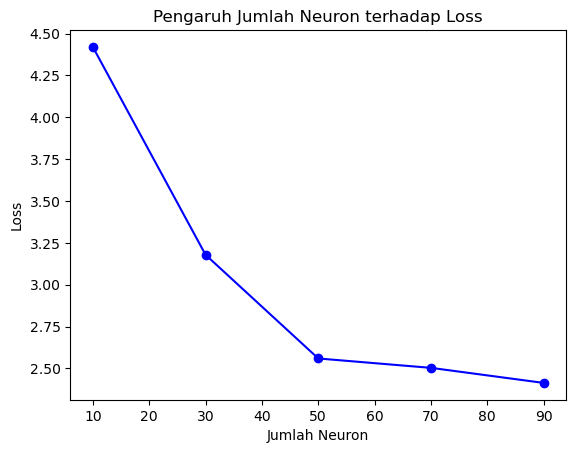

In [31]:
# Plot pengaruh jumlah neuron terhadap loss
plt.plot(neuron_range, losses2N_val1, 'bo-')
plt.xlabel('Jumlah Neuron')
plt.ylabel('Loss')
plt.title('Pengaruh Jumlah Neuron terhadap Loss')
plt.show()

In [ ]:
# Rentang jumlah neuron yang ingin dieksplorasi
neuron_range = range(85, 101)

# List untuk menyimpan loss
losses1N_val_2 = []
losses1N_2 = []

# Membuat dan melatih model untuk setiap jumlah neuron
for num_neurons in neuron_range:
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train2.shape[1], activation='selu'))
    model.add(Dense(y_train2.shape[1], activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    history1N = model.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=1000, batch_size=16)
    loss1N_val = history1N.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
    loss1N = history1N.history['loss'][-1]  # Mengambil loss pada epoch terakhir
    losses1N_val_2.append(loss1N_val)
    losses1N_2.append(loss1N)

np.save('losses2N_val_21_rev.npy', losses1N_val_2)
np.save('losses2N_21_rev.npy', losses1N_2)

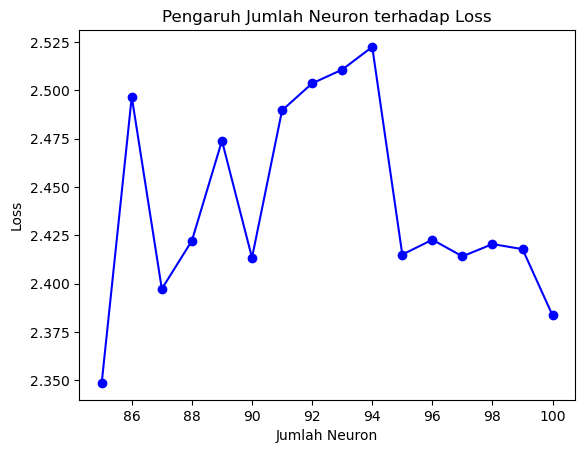

In [45]:
# Plot pengaruh jumlah neuron terhadap loss
plt.plot(neuron_range, losses1N_val_2, 'bo-')
plt.xlabel('Jumlah Neuron')
plt.ylabel('Loss')
plt.title('Pengaruh Jumlah Neuron terhadap Loss')
plt.show()

In [ ]:
# Kumpulan activation function yang ingin dieksplorasi
activation_functions = ['relu', 'sigmoid', 'tanh', 'softplus', 'softsign', 'selu', 'elu', 'exponential']
# Kumpulan optimizer yang ingin dieksplorasi
optimizers = ['adam', 'rmsprop', 'sgd', 'adadelta', 'adagrad', 'adamax', 'nadam', 'ftrl']

# List untuk menyimpan loss
losses2AO_val = []
losses2AO = []

# Membuat dan melatih model untuk setiap activation function
for activation_func in activation_functions:
    for optimizer in optimizers:
        np.random.seed(42)
        random.seed(42)
        tf.random.set_seed(42)    
        model2 = Sequential()
        model2.add(Dense(85, input_dim=X_train2.shape[1], activation=activation_func))
        model2.add(Dense(y_train2.shape[1], activation='linear'))
        model2.compile(loss='mean_absolute_error', optimizer=optimizer)
        history1AO = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=1000, batch_size=16)
        loss1AO_val = history1AO.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
        loss1AO = history1AO.history['loss'][-1]
        losses2AO.append(loss1AO)
        losses2AO_val.append(loss1AO_val)
        print(activation_func)
        print(optimizer)

In [49]:
np.save('losses2AO_rev.npy', losses2AO)
np.save('losses2AO_val_rev.npy', losses2AO_val)

# memanggil gunakan 'np.load()'

In [47]:
activation_functions = ['relu', 'sigmoid', 'tanh', 'softplus', 'softsign', 'selu', 'elu', 'exponential']
# Memisahkan data menjadi 8 bagian
relu = losses2AO_val[:8]
sigmoid = losses2AO_val[8:16]
tanh = losses2AO_val[16:24]
softplus = losses2AO_val[24:32]
softsign = losses2AO_val[32:40]
selu = losses2AO_val[40:48]
elu = losses2AO_val[48:56]
exponential = losses2AO_val[56:]

In [48]:
# Membuat DataFrame menggunakan pandas
df2AO = pd.DataFrame({'relu': relu, 'sigmoid': sigmoid, 'tanh': tanh, 'softplus': softplus, 'softsign': softsign, 'selu': selu, 'elu': elu, 'exponential': exponential})

df2AO.index = ['adam', 'rmsprop', 'sgd', 'adadelta', 'adagrad', 'adamax', 'nadam', 'ftrl']

# Menampilkan tabel
print(df2AO)

               relu    sigmoid       tanh   softplus   softsign       selu  \
adam       2.541383   2.562134   1.475486   3.726433   1.559824   2.348655   
rmsprop    2.802734   2.711826   1.555127   3.790374   1.582777   2.429881   
sgd        3.018372   5.199086   2.287672   4.148224   2.733170   2.589899   
adadelta  22.022015  18.678007  21.246862  18.106672  21.592194  20.796833   
adagrad   11.871577  15.734301  13.069813  12.824514  15.243035  11.275963   
adamax     4.388125   4.183975   2.416106   5.765324   2.775075   3.781706   
nadam      2.434039   2.529983   1.474646   3.702670   1.546473   2.395626   
ftrl      12.952882  15.693233  13.673973  13.145702  15.724501  12.261696   

                elu  exponential  
adam       2.577944     2.837045  
rmsprop    2.618197     3.022218  
sgd        3.202777     2.588099  
adadelta  21.281322    17.270790  
adagrad   11.916827    12.141798  
adamax     4.006006     4.209954  
nadam      2.592353     2.808925  
ftrl      12.5202

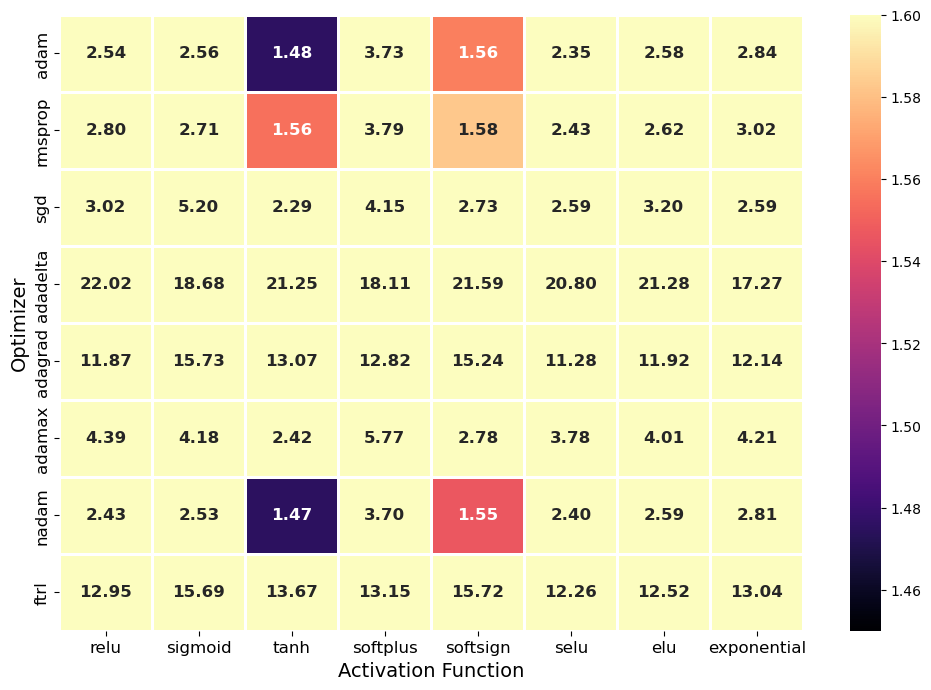

In [50]:
import seaborn as sns

# Membuat plot heatmap menggunakan seaborn
plt.figure(figsize=(12,8))
ax = sns.heatmap(df2AO, cmap='magma', vmin=1.45, vmax=1.6, linewidths=1, annot=True, fmt=".2f", annot_kws={"size": 12, "weight": "bold"})
# Mengatur label pada sumbu x dan sumbu y
ax.set_xlabel('Activation Function', fontsize=14)
ax.set_ylabel('Optimizer', fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
# Menampilkan plot
plt.show()

In [ ]:
# Rentang jumlah neuron yang ingin dieksplorasi
neuron_range = range(85, 101)

# List untuk menyimpan loss
losses1N_val_2 = []
losses1N_2 = []

# Membuat dan melatih model untuk setiap jumlah neuron
for num_neurons in neuron_range:
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train2.shape[1], activation='tanh'))
    model.add(Dense(y_train2.shape[1], activation='linear'))
    model.compile(loss='mean_absolute_error', optimizer='nadam')
    history1N = model.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=1000, batch_size=16)
    loss1N_val = history1N.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
    loss1N = history1N.history['loss'][-1]  # Mengambil loss pada epoch terakhir
    losses1N_val_2.append(loss1N_val)
    losses1N_2.append(loss1N)

np.save('losses2N_val_22_rev.npy', losses1N_val_2)
np.save('losses2N_22_rev.npy', losses1N_2)

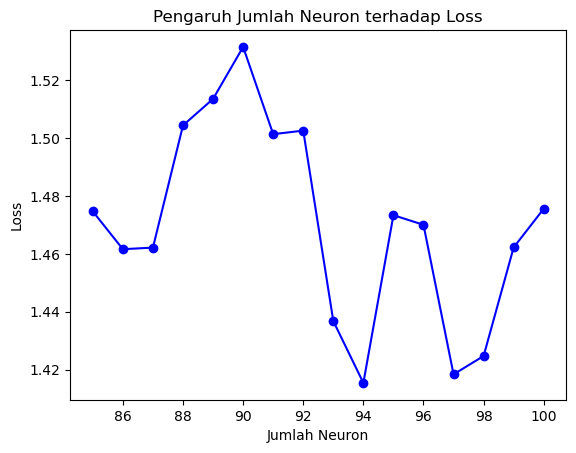

In [52]:
# Plot pengaruh jumlah neuron terhadap loss
plt.plot(neuron_range, losses1N_val_2, 'bo-')
plt.xlabel('Jumlah Neuron')
plt.ylabel('Loss')
plt.title('Pengaruh Jumlah Neuron terhadap Loss')
plt.show()

In [ ]:
# Rentang jumlah layer yang ingin dieksplorasi
layer_range = range(1, 6)

# List untuk menyimpan loss
losses2HL = []
losses2HL_val = []

# Membuat dan melatih model untuk setiap jumlah layer
for num_layers in layer_range:
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)    
    model2 = Sequential()
    model2.add(Dense(94, input_dim=X_train2.shape[1], activation='tanh'))
    for _ in range(num_layers-1):
        model2.add(Dense(94, activation='tanh'))
    model2.add(Dense(y_train2.shape[1], activation='linear'))
    model2.compile(loss='mean_absolute_error', optimizer='nadam')
    history1L = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=1000, batch_size=16)
    loss1HL = history1L.history['loss'][-1]  # Mengambil loss pada epoch terakhir
    loss1HL_val = history1L.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
    losses2HL.append(loss1HL)
    losses2HL_val.append(loss1HL_val)
    print(num_layers)

np.save('losses2HL_val1_rev.npy', losses2HL_val)
np.save('losses2HL1_rev.npy', losses2HL)

In [71]:
losses2HL_val = np.load('losses2HL_val1_rev.npy')
losses2HL_val

array([1.41542864, 0.71520126, 0.63684922, 0.59064823, 0.58851415])

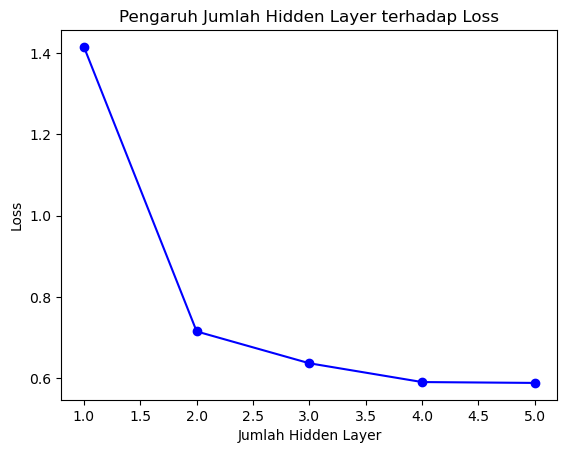

In [54]:
# Plot pengaruh jumlah neuron terhadap loss
plt.plot(layer_range, losses2HL_val, 'bo-')
plt.xlabel('Jumlah Hidden Layer')
plt.ylabel('Loss')
plt.title('Pengaruh Jumlah Hidden Layer terhadap Loss')
plt.show()

In [72]:
# Rentang jumlah layer yang ingin dieksplorasi
layer_range = range(6, 7)

# List untuk menyimpan loss
losses2HL = []
losses2HL_val = []

# Membuat dan melatih model untuk setiap jumlah layer
for num_layers in layer_range:
    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)    
    model2 = Sequential()
    model2.add(Dense(94, input_dim=X_train2.shape[1], activation='tanh'))
    for _ in range(num_layers-1):
        model2.add(Dense(94, activation='tanh'))
    model2.add(Dense(y_train2.shape[1], activation='linear'))
    model2.compile(loss='mean_absolute_error', optimizer='nadam')
    history1L = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=1000, batch_size=16)
    loss1HL = history1L.history['loss'][-1]  # Mengambil loss pada epoch terakhir
    loss1HL_val = history1L.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
    losses2HL.append(loss1HL)
    losses2HL_val.append(loss1HL_val)
    print(num_layers)

Epoch 1/1000
34/34 [==============================] - 3s 11ms/step - loss: 23.1926 - val_loss: 17.6818
Epoch 2/1000
34/34 [==============================] - 0s 4ms/step - loss: 19.6110 - val_loss: 15.6217
Epoch 3/1000
34/34 [==============================] - 0s 5ms/step - loss: 17.7572 - val_loss: 14.0562
Epoch 4/1000
34/34 [==============================] - 0s 4ms/step - loss: 16.1940 - val_loss: 12.8229
Epoch 5/1000
34/34 [==============================] - 0s 4ms/step - loss: 15.0383 - val_loss: 12.0115
Epoch 6/1000
34/34 [==============================] - 0s 4ms/step - loss: 14.1151 - val_loss: 11.2015
Epoch 7/1000
34/34 [==============================] - 0s 5ms/step - loss: 13.2375 - val_loss: 10.6340
Epoch 8/1000
34/34 [==============================] - 0s 5ms/step - loss: 12.4244 - val_loss: 9.7060
Epoch 9/1000
34/34 [==============================] - 0s 5ms/step - loss: 11.6653 - val_loss: 9.0325
Epoch 10/1000
34/34 [==============================] - 0s 4ms/step - loss: 10.9404 

34/34 [==============================] - 0s 4ms/step - loss: 1.0982 - val_loss: 1.0614
Epoch 83/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.1215 - val_loss: 1.0206
Epoch 84/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.1212 - val_loss: 1.0939
Epoch 85/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.1040 - val_loss: 0.9991
Epoch 86/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0820 - val_loss: 1.0980
Epoch 87/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0981 - val_loss: 1.0481
Epoch 88/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.1151 - val_loss: 1.0066
Epoch 89/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0551 - val_loss: 1.0994
Epoch 90/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0534 - val_loss: 1.0904
Epoch 91/1000
34/34 [==============================] - 0s 5ms/step - loss: 1.1076 - val_loss: 1.0776
Epoc

34/34 [==============================] - 0s 4ms/step - loss: 0.7977 - val_loss: 0.7902
Epoch 243/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8839 - val_loss: 0.7564
Epoch 244/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8018 - val_loss: 0.7762
Epoch 245/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8054 - val_loss: 0.7643
Epoch 246/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8802 - val_loss: 0.7745
Epoch 247/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7973 - val_loss: 0.7812
Epoch 248/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8186 - val_loss: 0.8411
Epoch 249/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8227 - val_loss: 0.8227
Epoch 250/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8257 - val_loss: 0.7541
Epoch 251/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8140 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.7163 - val_loss: 0.6897
Epoch 403/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6716 - val_loss: 0.6828
Epoch 404/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6646 - val_loss: 0.6911
Epoch 405/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6931 - val_loss: 0.7978
Epoch 406/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6818 - val_loss: 0.7759
Epoch 407/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6965 - val_loss: 0.7187
Epoch 408/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6789 - val_loss: 0.7323
Epoch 409/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6843 - val_loss: 0.6924
Epoch 410/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7201 - val_loss: 0.7565
Epoch 411/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7431 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.6289 - val_loss: 0.6987
Epoch 563/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6338 - val_loss: 0.6733
Epoch 564/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5909 - val_loss: 0.6956
Epoch 565/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5830 - val_loss: 0.7262
Epoch 566/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5797 - val_loss: 0.7022
Epoch 567/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6321 - val_loss: 0.7265
Epoch 568/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6032 - val_loss: 0.6488
Epoch 569/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6183 - val_loss: 0.7148
Epoch 570/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6061 - val_loss: 0.7619
Epoch 571/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6393 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5837 - val_loss: 0.7013
Epoch 723/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5965 - val_loss: 0.7601
Epoch 724/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5411 - val_loss: 0.6888
Epoch 725/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.5458 - val_loss: 0.7047
Epoch 726/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6003 - val_loss: 0.7589
Epoch 727/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6115 - val_loss: 0.7247
Epoch 728/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6251 - val_loss: 0.7341
Epoch 729/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6342 - val_loss: 0.7481
Epoch 730/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6145 - val_loss: 0.7031
Epoch 731/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5851 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5215 - val_loss: 0.8076
Epoch 883/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5272 - val_loss: 0.7561
Epoch 884/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5561 - val_loss: 0.7398
Epoch 885/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5291 - val_loss: 0.7228
Epoch 886/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5256 - val_loss: 0.7440
Epoch 887/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5189 - val_loss: 0.7357
Epoch 888/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5248 - val_loss: 0.7666
Epoch 889/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5668 - val_loss: 0.7457
Epoch 890/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5654 - val_loss: 0.7903
Epoch 891/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5269 - val_loss: 0.

In [73]:
loss1HL_val

0.6927220821380615

In [ ]:
# Rentang jumlah neuron yang ingin dieksplorasi
neuron_range = range(94, 101)
#neuron_range2 = [92]
#neuron range3 = [91]
#neuron_range4 = range(96, 101)

# List untuk menyimpan loss
losses2NHL_val = []
losses2NHL = []

# Membuat dan melatih model untuk setiap jumlah neuron
for num_neurons2 in neuron_range:
    for num_neurons3 in neuron_range:
        for num_neurons4 in neuron_range:
            np.random.seed(42)
            random.seed(42)
            tf.random.set_seed(42)
            model = Sequential()
            model.add(Dense(94, input_dim=X_train2.shape[1], activation='tanh'))
            model.add(Dense(num_neurons2, activation='tanh'))
            model.add(Dense(num_neurons3, activation='tanh'))        
            model.add(Dense(num_neurons4, activation='tanh'))        
            model.add(Dense(y_train2.shape[1], activation='linear'))
            model.compile(loss='mean_absolute_error', optimizer='nadam')
            history = model.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=1000, batch_size=16)
            loss_val = history.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
            loss = history.history['loss']
            losses2NHL_val.append(loss_val)
            losses2NHL.append(loss)

np.save('losses2NHL_val2_rev.npy', losses2NHL_val)
np.save('losses2NHL2_rev.npy', losses2NHL)

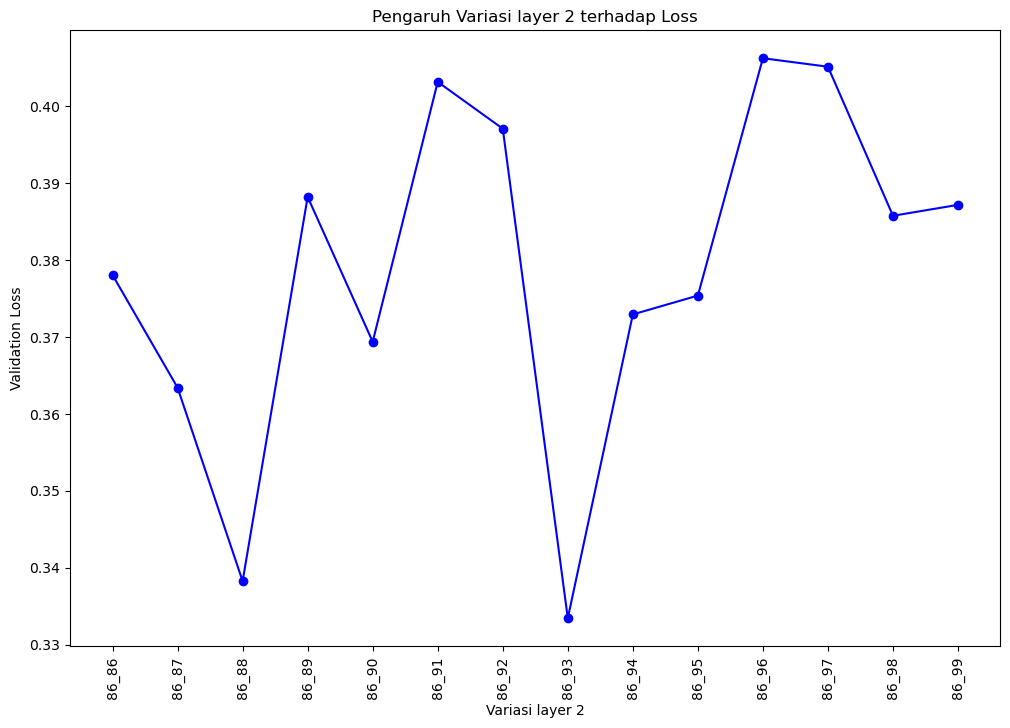

In [19]:
# Plot pengaruh jumlah neuron terhadap loss
neuron2 = ['86_86','86_87','86_88','86_89','86_90',
          '86_91','86_92','86_93','86_94','86_95',
          '86_96','86_97','86_98','86_99']
plt.figure(figsize=(12, 8))
plt.plot(neuron2, losses2NHL_val, 'bo-')
plt.xticks(rotation=90)
plt.xlabel('Variasi layer 2')
plt.ylabel('Validation Loss')
plt.title('Pengaruh Variasi layer 2 terhadap Loss')
plt.show()

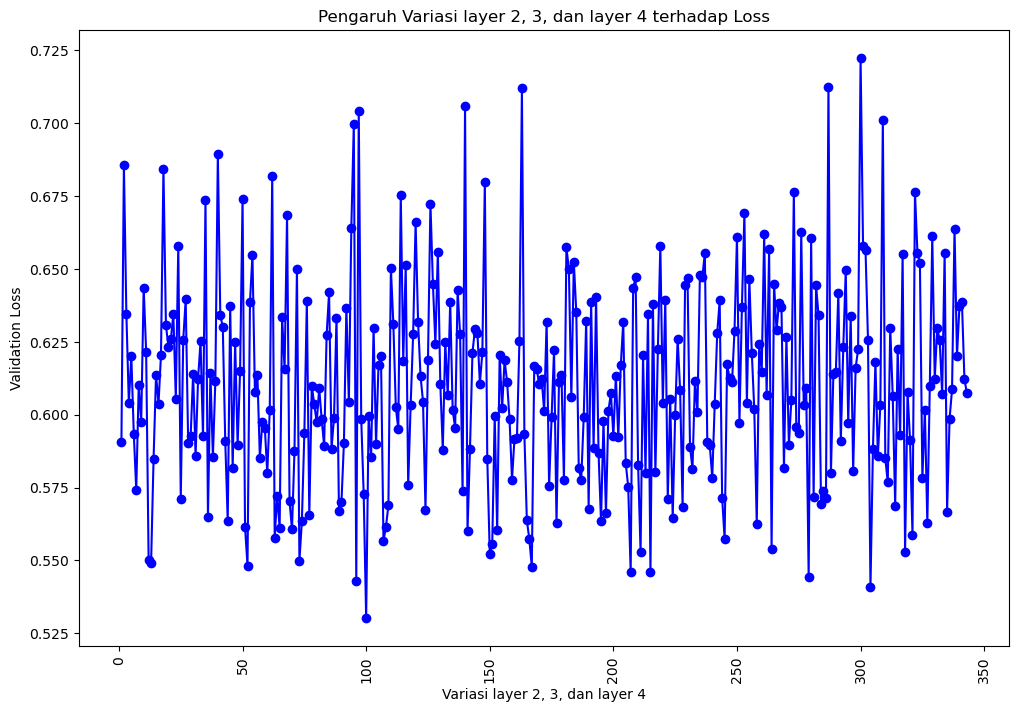

In [57]:
# Plot pengaruh jumlah neuron terhadap loss
neuron2_3_4 = range(1,344)
plt.figure(figsize=(12, 8))
plt.plot(neuron2_3_4, losses2NHL_val, 'bo-')
# Mengatur rotasi xlabel
plt.xticks(rotation=90)
plt.xlabel('Variasi layer 2, 3, dan layer 4')
plt.ylabel('Validation Loss')
plt.title('Pengaruh Variasi layer 2, 3, dan layer 4 terhadap Loss')
plt.show()

In [75]:
# Rentang jumlah neuron yang ingin dieksplorasi
#neuron_range = range(94, 101)
neuron_range2 = [96]
neuron_range3 = [94]
neuron_range4 = [95]
neuron_range5 = range(94,101)

# List untuk menyimpan loss
losses2NHL_val = []
losses2NHL = []

# Membuat dan melatih model untuk setiap jumlah neuron
for num_neurons2 in neuron_range2:
    for num_neurons3 in neuron_range3:
        for num_neurons4 in neuron_range4:
            for num_neurons5 in neuron_range5:
                np.random.seed(42)
                random.seed(42)
                tf.random.set_seed(42)
                model = Sequential()
                model.add(Dense(94, input_dim=X_train2.shape[1], activation='tanh'))
                model.add(Dense(num_neurons2, activation='tanh'))
                model.add(Dense(num_neurons3, activation='tanh'))        
                model.add(Dense(num_neurons4, activation='tanh'))  
                model.add(Dense(num_neurons5, activation='tanh'))
                model.add(Dense(y_train2.shape[1], activation='linear'))
                model.compile(loss='mean_absolute_error', optimizer='nadam')
                history = model.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=1000, batch_size=16)
                loss_val = history.history['val_loss'][-1]  # Mengambil loss pada epoch terakhir
                loss = history.history['loss']
                losses2NHL_val.append(loss_val)
                losses2NHL.append(loss)

Epoch 1/1000
34/34 [==============================] - 3s 10ms/step - loss: 23.5228 - val_loss: 17.4637
Epoch 2/1000
34/34 [==============================] - 0s 4ms/step - loss: 19.4857 - val_loss: 15.6262
Epoch 3/1000
34/34 [==============================] - 0s 3ms/step - loss: 17.7727 - val_loss: 14.2350
Epoch 4/1000
34/34 [==============================] - 0s 4ms/step - loss: 16.3425 - val_loss: 13.0451
Epoch 5/1000
34/34 [==============================] - 0s 4ms/step - loss: 15.0599 - val_loss: 11.9855
Epoch 6/1000
34/34 [==============================] - 0s 4ms/step - loss: 14.0864 - val_loss: 11.3277
Epoch 7/1000
34/34 [==============================] - 0s 4ms/step - loss: 13.2698 - val_loss: 10.5557
Epoch 8/1000
34/34 [==============================] - 0s 4ms/step - loss: 12.4520 - val_loss: 9.8253
Epoch 9/1000
34/34 [==============================] - 0s 4ms/step - loss: 11.7087 - val_loss: 9.1675
Epoch 10/1000
34/34 [==============================] - 0s 4ms/step - loss: 10.9460 

34/34 [==============================] - 0s 4ms/step - loss: 1.0661 - val_loss: 1.0332
Epoch 83/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0911 - val_loss: 1.1916
Epoch 84/1000
34/34 [==============================] - 0s 5ms/step - loss: 1.0763 - val_loss: 1.0485
Epoch 85/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0459 - val_loss: 1.0390
Epoch 86/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0589 - val_loss: 0.9933
Epoch 87/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0639 - val_loss: 1.1261
Epoch 88/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0588 - val_loss: 0.9470
Epoch 89/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0262 - val_loss: 0.9527
Epoch 90/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0412 - val_loss: 1.0375
Epoch 91/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0808 - val_loss: 0.9601
Epoc

34/34 [==============================] - 0s 3ms/step - loss: 0.7740 - val_loss: 0.8410
Epoch 243/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8433 - val_loss: 0.6793
Epoch 244/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7925 - val_loss: 0.7257
Epoch 245/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7900 - val_loss: 0.6792
Epoch 246/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7935 - val_loss: 0.6885
Epoch 247/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7891 - val_loss: 0.7454
Epoch 248/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8220 - val_loss: 0.7565
Epoch 249/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7928 - val_loss: 0.7315
Epoch 250/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8120 - val_loss: 0.6787
Epoch 251/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7767 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.7171 - val_loss: 0.6298
Epoch 403/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6903 - val_loss: 0.6448
Epoch 404/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6636 - val_loss: 0.5843
Epoch 405/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6570 - val_loss: 0.5854
Epoch 406/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6537 - val_loss: 0.6899
Epoch 407/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7042 - val_loss: 0.6471
Epoch 408/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.6806 - val_loss: 0.6341
Epoch 409/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6718 - val_loss: 0.6241
Epoch 410/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6616 - val_loss: 0.6037
Epoch 411/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6828 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.6061 - val_loss: 0.7210
Epoch 563/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6532 - val_loss: 0.5633
Epoch 564/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6204 - val_loss: 0.5730
Epoch 565/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6442 - val_loss: 0.6683
Epoch 566/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6329 - val_loss: 0.5869
Epoch 567/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6113 - val_loss: 0.5447
Epoch 568/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5952 - val_loss: 0.5548
Epoch 569/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6195 - val_loss: 0.7278
Epoch 570/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6328 - val_loss: 0.6237
Epoch 571/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6492 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5590 - val_loss: 0.5553
Epoch 723/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5774 - val_loss: 0.5647
Epoch 724/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5758 - val_loss: 0.6077
Epoch 725/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5770 - val_loss: 0.5903
Epoch 726/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5781 - val_loss: 0.6435
Epoch 727/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5843 - val_loss: 0.5761
Epoch 728/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5720 - val_loss: 0.5360
Epoch 729/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5704 - val_loss: 0.5871
Epoch 730/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6013 - val_loss: 0.5837
Epoch 731/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5841 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5413 - val_loss: 0.5489
Epoch 883/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5384 - val_loss: 0.5590
Epoch 884/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5416 - val_loss: 0.5793
Epoch 885/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5278 - val_loss: 0.5863
Epoch 886/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5256 - val_loss: 0.6425
Epoch 887/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5357 - val_loss: 0.6174
Epoch 888/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5177 - val_loss: 0.5834
Epoch 889/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5372 - val_loss: 0.5953
Epoch 890/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5301 - val_loss: 0.5665
Epoch 891/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5407 - val_loss: 0.

Epoch 43/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.5830 - val_loss: 1.4448
Epoch 44/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.5597 - val_loss: 1.4993
Epoch 45/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.5479 - val_loss: 1.2551
Epoch 46/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.4627 - val_loss: 1.3000
Epoch 47/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.4230 - val_loss: 1.3625
Epoch 48/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.4234 - val_loss: 1.1949
Epoch 49/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.3993 - val_loss: 1.4461
Epoch 50/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.3821 - val_loss: 1.2494
Epoch 51/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.3409 - val_loss: 1.2267
Epoch 52/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.3530 - val_los

Epoch 124/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.9232 - val_loss: 0.8411
Epoch 125/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.9437 - val_loss: 0.9177
Epoch 126/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9415 - val_loss: 0.7951
Epoch 127/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.9272 - val_loss: 0.8130
Epoch 128/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9250 - val_loss: 1.0389
Epoch 129/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9387 - val_loss: 0.8922
Epoch 130/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.9509 - val_loss: 0.8342
Epoch 131/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9416 - val_loss: 0.8389
Epoch 132/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9221 - val_loss: 0.8353
Epoch 133/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8812

34/34 [==============================] - 0s 3ms/step - loss: 0.7435 - val_loss: 0.7312
Epoch 285/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7751 - val_loss: 0.6259
Epoch 286/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7319 - val_loss: 0.6329
Epoch 287/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7475 - val_loss: 0.6779
Epoch 288/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7464 - val_loss: 0.7500
Epoch 289/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7647 - val_loss: 0.7187
Epoch 290/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7874 - val_loss: 0.6837
Epoch 291/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7500 - val_loss: 0.6636
Epoch 292/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7688 - val_loss: 0.7483
Epoch 293/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.8014 - val_loss: 0.

34/34 [==============================] - 0s 3ms/step - loss: 0.6512 - val_loss: 0.5768
Epoch 445/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6730 - val_loss: 0.6408
Epoch 446/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6406 - val_loss: 0.7886
Epoch 447/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6992 - val_loss: 0.6140
Epoch 448/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6659 - val_loss: 0.6631
Epoch 449/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6602 - val_loss: 0.6013
Epoch 450/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6667 - val_loss: 0.6141
Epoch 451/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6341 - val_loss: 0.7336
Epoch 452/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6549 - val_loss: 0.5891
Epoch 453/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6432 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.6024 - val_loss: 0.5913
Epoch 605/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6410 - val_loss: 0.5631
Epoch 606/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6229 - val_loss: 0.5864
Epoch 607/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5836 - val_loss: 0.5955
Epoch 608/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6076 - val_loss: 0.5624
Epoch 609/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6064 - val_loss: 0.5976
Epoch 610/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.6084 - val_loss: 0.6133
Epoch 611/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6420 - val_loss: 0.5867
Epoch 612/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5949 - val_loss: 0.5763
Epoch 613/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5777 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5671 - val_loss: 0.6305
Epoch 765/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5981 - val_loss: 0.5583
Epoch 766/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5760 - val_loss: 0.5882
Epoch 767/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5891 - val_loss: 0.5877
Epoch 768/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6071 - val_loss: 0.5689
Epoch 769/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5529 - val_loss: 0.5668
Epoch 770/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5593 - val_loss: 0.5688
Epoch 771/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5474 - val_loss: 0.5396
Epoch 772/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5347 - val_loss: 0.5879
Epoch 773/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5576 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5131 - val_loss: 0.5973
Epoch 925/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5234 - val_loss: 0.5577
Epoch 926/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5071 - val_loss: 0.5912
Epoch 927/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5176 - val_loss: 0.5262
Epoch 928/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5458 - val_loss: 0.6768
Epoch 929/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5560 - val_loss: 0.5510
Epoch 930/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5311 - val_loss: 0.6078
Epoch 931/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5284 - val_loss: 0.5625
Epoch 932/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5248 - val_loss: 0.6037
Epoch 933/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5026 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 1.0528 - val_loss: 0.9407
Epoch 86/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0498 - val_loss: 0.9754
Epoch 87/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0472 - val_loss: 1.0377
Epoch 88/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0661 - val_loss: 1.0276
Epoch 89/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0770 - val_loss: 0.9743
Epoch 90/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0497 - val_loss: 0.9887
Epoch 91/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0593 - val_loss: 0.9848
Epoch 92/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0836 - val_loss: 1.1291
Epoch 93/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.0358 - val_loss: 0.9989
Epoch 94/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9889 - val_loss: 0.9523
Epoc

34/34 [==============================] - 0s 4ms/step - loss: 0.7779 - val_loss: 0.7187
Epoch 246/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8157 - val_loss: 0.7559
Epoch 247/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7844 - val_loss: 0.7217
Epoch 248/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7918 - val_loss: 0.7455
Epoch 249/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7907 - val_loss: 0.7169
Epoch 250/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7579 - val_loss: 0.7809
Epoch 251/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7804 - val_loss: 0.6572
Epoch 252/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7777 - val_loss: 0.6582
Epoch 253/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7881 - val_loss: 0.7275
Epoch 254/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.8234 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.7059 - val_loss: 0.6622
Epoch 406/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6998 - val_loss: 0.6079
Epoch 407/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6785 - val_loss: 0.7180
Epoch 408/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6963 - val_loss: 0.7121
Epoch 409/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6980 - val_loss: 0.6615
Epoch 410/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6976 - val_loss: 0.6277
Epoch 411/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6728 - val_loss: 0.6210
Epoch 412/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6961 - val_loss: 0.6422
Epoch 413/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6846 - val_loss: 0.6687
Epoch 414/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6866 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.6575 - val_loss: 0.6166
Epoch 566/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5986 - val_loss: 0.5856
Epoch 567/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6292 - val_loss: 0.6111
Epoch 568/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6038 - val_loss: 0.5661
Epoch 569/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6279 - val_loss: 0.6954
Epoch 570/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6361 - val_loss: 0.5972
Epoch 571/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6588 - val_loss: 0.6161
Epoch 572/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5997 - val_loss: 0.5862
Epoch 573/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6095 - val_loss: 0.6225
Epoch 574/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6092 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5531 - val_loss: 0.6193
Epoch 726/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5773 - val_loss: 0.6111
Epoch 727/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5697 - val_loss: 0.6037
Epoch 728/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5741 - val_loss: 0.5860
Epoch 729/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5659 - val_loss: 0.6011
Epoch 730/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5600 - val_loss: 0.5880
Epoch 731/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5620 - val_loss: 0.5524
Epoch 732/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5689 - val_loss: 0.5773
Epoch 733/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6027 - val_loss: 0.6142
Epoch 734/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5622 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5497 - val_loss: 0.6179
Epoch 886/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6406 - val_loss: 0.6350
Epoch 887/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5338 - val_loss: 0.5663
Epoch 888/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.4993 - val_loss: 0.6140
Epoch 889/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5681 - val_loss: 0.5803
Epoch 890/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5444 - val_loss: 0.5969
Epoch 891/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5121 - val_loss: 0.5579
Epoch 892/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5141 - val_loss: 0.6180
Epoch 893/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5355 - val_loss: 0.5993
Epoch 894/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5124 - val_loss: 0.

Epoch 46/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.5009 - val_loss: 1.4558
Epoch 47/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.4632 - val_loss: 1.4766
Epoch 48/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.4059 - val_loss: 1.3014
Epoch 49/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.4400 - val_loss: 1.4712
Epoch 50/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.3504 - val_loss: 1.2350
Epoch 51/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.3575 - val_loss: 1.2792
Epoch 52/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.3540 - val_loss: 1.2473
Epoch 53/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.3161 - val_loss: 1.2383
Epoch 54/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.3485 - val_loss: 1.1351
Epoch 55/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.2692 - val_los

Epoch 127/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9515 - val_loss: 0.8634
Epoch 128/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9676 - val_loss: 0.8882
Epoch 129/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9338 - val_loss: 0.9394
Epoch 130/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9474 - val_loss: 0.8232
Epoch 131/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9157 - val_loss: 0.8653
Epoch 132/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9191 - val_loss: 0.8786
Epoch 133/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9473 - val_loss: 0.8812
Epoch 134/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9541 - val_loss: 0.8026
Epoch 135/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9172 - val_loss: 0.8825
Epoch 136/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9225

34/34 [==============================] - 0s 3ms/step - loss: 0.7810 - val_loss: 0.6946
Epoch 288/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7609 - val_loss: 0.6810
Epoch 289/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.7610 - val_loss: 0.7081
Epoch 290/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7128 - val_loss: 0.7515
Epoch 291/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7516 - val_loss: 0.7507
Epoch 292/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7680 - val_loss: 0.7085
Epoch 293/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7771 - val_loss: 0.7029
Epoch 294/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7458 - val_loss: 0.6533
Epoch 295/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7701 - val_loss: 0.6631
Epoch 296/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7594 - val_loss: 0.

34/34 [==============================] - 0s 3ms/step - loss: 0.6856 - val_loss: 0.6089
Epoch 448/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6756 - val_loss: 0.6903
Epoch 449/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6683 - val_loss: 0.5499
Epoch 450/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6422 - val_loss: 0.6314
Epoch 451/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6582 - val_loss: 0.6234
Epoch 452/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6586 - val_loss: 0.6082
Epoch 453/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6578 - val_loss: 0.6243
Epoch 454/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6961 - val_loss: 0.6024
Epoch 455/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6441 - val_loss: 0.6672
Epoch 456/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6565 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.6198 - val_loss: 0.5881
Epoch 608/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5838 - val_loss: 0.5853
Epoch 609/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6219 - val_loss: 0.6165
Epoch 610/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6399 - val_loss: 0.6294
Epoch 611/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6104 - val_loss: 0.5806
Epoch 612/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5898 - val_loss: 0.6406
Epoch 613/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6069 - val_loss: 0.5867
Epoch 614/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.5891 - val_loss: 0.6144
Epoch 615/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6031 - val_loss: 0.6019
Epoch 616/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5912 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5446 - val_loss: 0.6227
Epoch 768/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5425 - val_loss: 0.5708
Epoch 769/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5489 - val_loss: 0.6784
Epoch 770/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5580 - val_loss: 0.6547
Epoch 771/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5474 - val_loss: 0.5804
Epoch 772/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5552 - val_loss: 0.6140
Epoch 773/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5765 - val_loss: 0.5948
Epoch 774/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5492 - val_loss: 0.6096
Epoch 775/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5902 - val_loss: 0.6599
Epoch 776/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5435 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5134 - val_loss: 0.6035
Epoch 928/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5537 - val_loss: 0.6211
Epoch 929/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5252 - val_loss: 0.5948
Epoch 930/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5245 - val_loss: 0.6935
Epoch 931/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6022 - val_loss: 0.6162
Epoch 932/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5377 - val_loss: 0.6064
Epoch 933/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.4957 - val_loss: 0.6376
Epoch 934/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5425 - val_loss: 0.6315
Epoch 935/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5248 - val_loss: 0.6123
Epoch 936/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5104 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 1.0465 - val_loss: 1.0079
Epoch 89/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.0091 - val_loss: 1.0695
Epoch 90/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.0158 - val_loss: 0.9690
Epoch 91/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.0608 - val_loss: 0.9928
Epoch 92/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.0388 - val_loss: 1.1891
Epoch 93/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.0210 - val_loss: 0.9637
Epoch 94/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.9994 - val_loss: 0.9551
Epoch 95/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0291 - val_loss: 0.9894
Epoch 96/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0196 - val_loss: 0.9887
Epoch 97/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0444 - val_loss: 0.9446
Epoc

34/34 [==============================] - 0s 4ms/step - loss: 0.8104 - val_loss: 0.8111
Epoch 249/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8065 - val_loss: 0.7850
Epoch 250/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7993 - val_loss: 0.7093
Epoch 251/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7864 - val_loss: 0.6907
Epoch 252/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7811 - val_loss: 0.6607
Epoch 253/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.8020 - val_loss: 0.7415
Epoch 254/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7995 - val_loss: 0.7129
Epoch 255/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7802 - val_loss: 0.6934
Epoch 256/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7940 - val_loss: 0.6917
Epoch 257/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7812 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.6624 - val_loss: 0.6601
Epoch 409/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6791 - val_loss: 0.7133
Epoch 410/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7016 - val_loss: 0.6810
Epoch 411/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6864 - val_loss: 0.6319
Epoch 412/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6522 - val_loss: 0.6061
Epoch 413/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6543 - val_loss: 0.6394
Epoch 414/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6650 - val_loss: 0.7258
Epoch 415/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6794 - val_loss: 0.6242
Epoch 416/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6549 - val_loss: 0.7544
Epoch 417/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7519 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.6000 - val_loss: 0.6312
Epoch 569/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6078 - val_loss: 0.6653
Epoch 570/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6264 - val_loss: 0.6391
Epoch 571/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6211 - val_loss: 0.6286
Epoch 572/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6048 - val_loss: 0.5879
Epoch 573/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6358 - val_loss: 0.6420
Epoch 574/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6229 - val_loss: 0.5950
Epoch 575/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6133 - val_loss: 0.6328
Epoch 576/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6173 - val_loss: 0.6636
Epoch 577/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6212 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5778 - val_loss: 0.6522
Epoch 729/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5722 - val_loss: 0.6179
Epoch 730/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5609 - val_loss: 0.6149
Epoch 731/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5578 - val_loss: 0.6330
Epoch 732/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5798 - val_loss: 0.6423
Epoch 733/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5970 - val_loss: 0.6416
Epoch 734/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5625 - val_loss: 0.6070
Epoch 735/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5259 - val_loss: 0.6071
Epoch 736/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5664 - val_loss: 0.7180
Epoch 737/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5628 - val_loss: 0.

34/34 [==============================] - 0s 3ms/step - loss: 0.5288 - val_loss: 0.6697
Epoch 889/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5567 - val_loss: 0.6687
Epoch 890/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5474 - val_loss: 0.6310
Epoch 891/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5199 - val_loss: 0.6091
Epoch 892/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5200 - val_loss: 0.6641
Epoch 893/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5147 - val_loss: 0.6316
Epoch 894/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5125 - val_loss: 0.6731
Epoch 895/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5166 - val_loss: 0.6246
Epoch 896/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5295 - val_loss: 0.6604
Epoch 897/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5231 - val_loss: 0.

Epoch 49/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.3673 - val_loss: 1.2158
Epoch 50/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.3408 - val_loss: 1.2946
Epoch 51/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.3380 - val_loss: 1.3250
Epoch 52/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.3107 - val_loss: 1.1774
Epoch 53/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.2674 - val_loss: 1.2027
Epoch 54/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.3414 - val_loss: 1.2149
Epoch 55/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.2422 - val_loss: 1.0936
Epoch 56/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.2111 - val_loss: 1.3431
Epoch 57/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.2451 - val_loss: 1.1789
Epoch 58/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.2649 - val_los

Epoch 130/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.9689 - val_loss: 0.8455
Epoch 131/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9223 - val_loss: 0.8597
Epoch 132/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9413 - val_loss: 0.8146
Epoch 133/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9239 - val_loss: 0.8676
Epoch 134/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9552 - val_loss: 0.8676
Epoch 135/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9449 - val_loss: 0.8897
Epoch 136/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9225 - val_loss: 0.8564
Epoch 137/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.9316 - val_loss: 0.8113
Epoch 138/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.9211 - val_loss: 0.8897
Epoch 139/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.9006

34/34 [==============================] - 0s 4ms/step - loss: 0.7745 - val_loss: 0.7511
Epoch 291/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7558 - val_loss: 0.6870
Epoch 292/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7454 - val_loss: 0.8291
Epoch 293/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.8055 - val_loss: 0.7364
Epoch 294/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7336 - val_loss: 0.7648
Epoch 295/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7560 - val_loss: 0.7481
Epoch 296/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7764 - val_loss: 0.6950
Epoch 297/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7961 - val_loss: 0.7487
Epoch 298/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7742 - val_loss: 0.7654
Epoch 299/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7677 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.6578 - val_loss: 0.6355
Epoch 451/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6689 - val_loss: 0.7145
Epoch 452/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6546 - val_loss: 0.5848
Epoch 453/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6731 - val_loss: 0.6608
Epoch 454/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6975 - val_loss: 0.6449
Epoch 455/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6691 - val_loss: 0.6437
Epoch 456/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6443 - val_loss: 0.6675
Epoch 457/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6740 - val_loss: 0.6296
Epoch 458/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6796 - val_loss: 0.6374
Epoch 459/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6947 - val_loss: 0.

34/34 [==============================] - 0s 3ms/step - loss: 0.6263 - val_loss: 0.6872
Epoch 611/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6308 - val_loss: 0.5688
Epoch 612/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5757 - val_loss: 0.6184
Epoch 613/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5950 - val_loss: 0.5777
Epoch 614/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5908 - val_loss: 0.6427
Epoch 615/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5836 - val_loss: 0.6035
Epoch 616/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5880 - val_loss: 0.5967
Epoch 617/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5985 - val_loss: 0.5730
Epoch 618/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5981 - val_loss: 0.6474
Epoch 619/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6301 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5736 - val_loss: 0.5824
Epoch 771/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5567 - val_loss: 0.6002
Epoch 772/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5332 - val_loss: 0.5746
Epoch 773/1000
34/34 [==============================] - 0s 6ms/step - loss: 0.5103 - val_loss: 0.6019
Epoch 774/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5627 - val_loss: 0.5768
Epoch 775/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5732 - val_loss: 0.6136
Epoch 776/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5574 - val_loss: 0.6010
Epoch 777/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5703 - val_loss: 0.6604
Epoch 778/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5554 - val_loss: 0.6171
Epoch 779/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5797 - val_loss: 0.

34/34 [==============================] - 0s 3ms/step - loss: 0.5296 - val_loss: 0.6129
Epoch 931/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5295 - val_loss: 0.5923
Epoch 932/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5175 - val_loss: 0.6296
Epoch 933/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5095 - val_loss: 0.6067
Epoch 934/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5295 - val_loss: 0.6061
Epoch 935/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5233 - val_loss: 0.6002
Epoch 936/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5168 - val_loss: 0.5895
Epoch 937/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5347 - val_loss: 0.6354
Epoch 938/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5001 - val_loss: 0.5863
Epoch 939/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.4971 - val_loss: 0.

34/34 [==============================] - 0s 3ms/step - loss: 1.0045 - val_loss: 0.8450
Epoch 92/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0525 - val_loss: 1.0501
Epoch 93/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0092 - val_loss: 1.0032
Epoch 94/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0111 - val_loss: 0.9937
Epoch 95/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.0280 - val_loss: 0.9324
Epoch 96/1000
34/34 [==============================] - 0s 3ms/step - loss: 1.0178 - val_loss: 0.9326
Epoch 97/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.9855 - val_loss: 0.9960
Epoch 98/1000
34/34 [==============================] - 0s 4ms/step - loss: 1.0041 - val_loss: 0.8850
Epoch 99/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9806 - val_loss: 0.9290
Epoch 100/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.9759 - val_loss: 0.9216
Epo

34/34 [==============================] - 0s 4ms/step - loss: 0.7923 - val_loss: 0.6625
Epoch 252/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7749 - val_loss: 0.6480
Epoch 253/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7902 - val_loss: 0.6912
Epoch 254/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7945 - val_loss: 0.6784
Epoch 255/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7669 - val_loss: 0.7045
Epoch 256/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7827 - val_loss: 0.7303
Epoch 257/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7403 - val_loss: 0.7481
Epoch 258/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7912 - val_loss: 0.7194
Epoch 259/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7612 - val_loss: 0.6789
Epoch 260/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7814 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.6821 - val_loss: 0.6693
Epoch 412/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6814 - val_loss: 0.6297
Epoch 413/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6730 - val_loss: 0.6231
Epoch 414/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6814 - val_loss: 0.5971
Epoch 415/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6522 - val_loss: 0.5760
Epoch 416/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.7010 - val_loss: 0.6479
Epoch 417/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7116 - val_loss: 0.6011
Epoch 418/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6567 - val_loss: 0.6052
Epoch 419/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6763 - val_loss: 0.5974
Epoch 420/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6639 - val_loss: 0.

34/34 [==============================] - 0s 3ms/step - loss: 0.6202 - val_loss: 0.5568
Epoch 572/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6105 - val_loss: 0.5772
Epoch 573/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6281 - val_loss: 0.6312
Epoch 574/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5997 - val_loss: 0.5739
Epoch 575/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6436 - val_loss: 0.6230
Epoch 576/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6225 - val_loss: 0.5673
Epoch 577/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5853 - val_loss: 0.6450
Epoch 578/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6072 - val_loss: 0.5596
Epoch 579/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6083 - val_loss: 0.6031
Epoch 580/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.6023 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.6506 - val_loss: 0.5673
Epoch 732/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5628 - val_loss: 0.5828
Epoch 733/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5690 - val_loss: 0.5634
Epoch 734/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.6080 - val_loss: 0.5628
Epoch 735/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5628 - val_loss: 0.6011
Epoch 736/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5796 - val_loss: 0.5710
Epoch 737/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.5509 - val_loss: 0.5764
Epoch 738/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5471 - val_loss: 0.6464
Epoch 739/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5751 - val_loss: 0.5650
Epoch 740/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5580 - val_loss: 0.

34/34 [==============================] - 0s 4ms/step - loss: 0.5369 - val_loss: 0.6224
Epoch 892/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5395 - val_loss: 0.6399
Epoch 893/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5124 - val_loss: 0.5978
Epoch 894/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5135 - val_loss: 0.5847
Epoch 895/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5352 - val_loss: 0.5534
Epoch 896/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5466 - val_loss: 0.6243
Epoch 897/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5231 - val_loss: 0.6007
Epoch 898/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5450 - val_loss: 0.5781
Epoch 899/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5414 - val_loss: 0.5745
Epoch 900/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.5785 - val_loss: 0.

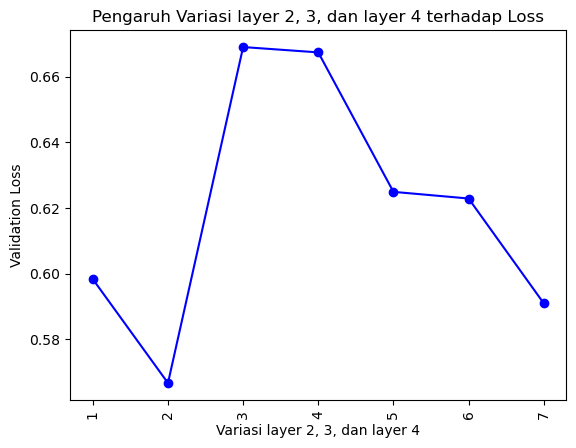

In [76]:
# Plot pengaruh jumlah neuron terhadap loss
neuron2_3_4 = range(1,8)
plt.figure()
plt.plot(neuron2_3_4, losses2NHL_val, 'bo-')
# Mengatur rotasi xlabel
plt.xticks(rotation=90)
plt.xlabel('Variasi layer 2, 3, dan layer 4')
plt.ylabel('Validation Loss')
plt.title('Pengaruh Variasi layer 2, 3, dan layer 4 terhadap Loss')
plt.show()

In [77]:
losses2NHL_val

[0.5983365178108215,
 0.5666684508323669,
 0.6690839529037476,
 0.6674532294273376,
 0.6249462962150574,
 0.6229175925254822,
 0.5909849405288696]

In [ ]:
# Variasi untuk jumlah epochs
epochs_values = [1000, 2000, 4000]
# Variasi untuk ukuran batch (batch_size)
batch_sizes = [16, 32, 64]
# List untuk menyimpan loss
losses2EB20 = []
losses2EB_val20 = []

for epochs in epochs_values:
    for batch_size in batch_sizes:
        np.random.seed(42)
        random.seed(42)
        tf.random.set_seed(42)
        model2 = Sequential()
        model2.add(Dense(94, input_dim=X_train2.shape[1], activation='tanh'))
        model2.add(Dense(96, activation='tanh'))
        model2.add(Dense(94, activation='tanh'))
        model2.add(Dense(95, activation='tanh'))
        model2.add(Dense(y_train2.shape[1], activation='linear'))
        model2.compile(loss='mean_absolute_error', optimizer='nadam')
    
        start_time = time.time()
        history = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=epochs, batch_size=batch_size)
        end_time = time.time()
        loss_e = history.history['loss'][-1]
        loss_e_val = history.history['val_loss'][-1]
        losses2EB20.append(loss_e)
        losses2EB_val20.append(loss_e_val)
  #  print(f"Training with {epochs} epochs took {end_time - start_time} seconds. Final loss: {loss[-1]}")
np.save('losses2EB_val_rev.npy', losses2EB_val20)
np.save('losses2EB_rev.npy', losses2EB20)

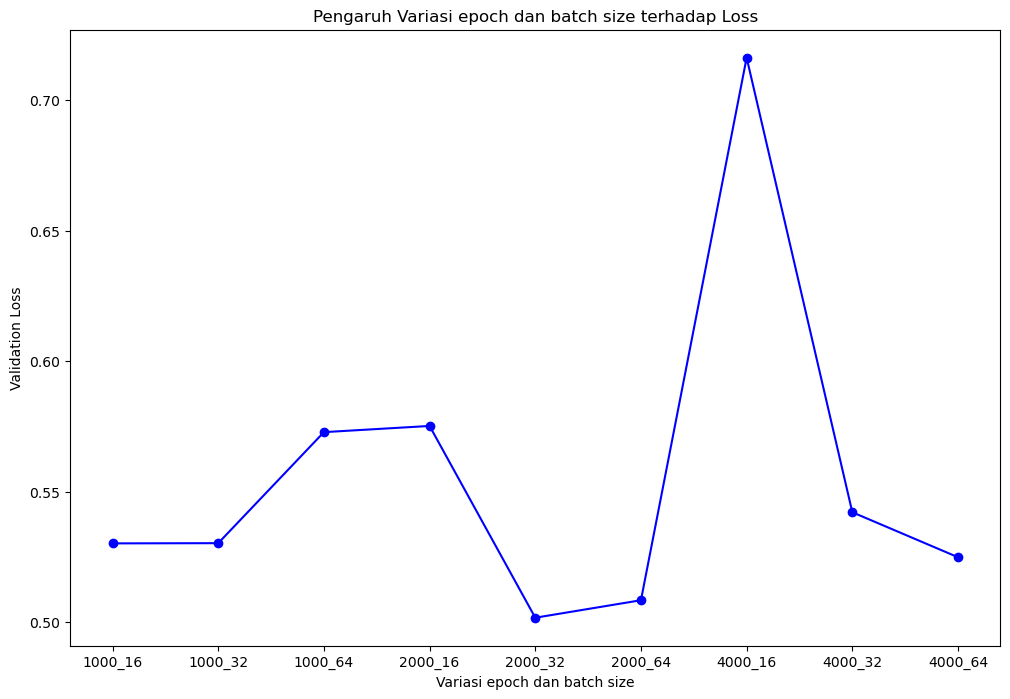

In [59]:
# Plot pengaruh jumlah neuron terhadap loss
epoch_batch = ['1000_16','1000_32','1000_64',
               '2000_16','2000_32','2000_64',
               '4000_16','4000_32','4000_64']
plt.figure(figsize=(12, 8))
plt.plot(epoch_batch, losses2EB_val20, 'bo-')
plt.xlabel('Variasi epoch dan batch size')
plt.ylabel('Validation Loss')
plt.title('Pengaruh Variasi epoch dan batch size terhadap Loss')
plt.show()

In [60]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

losses2_val20=[]
losses220=[]

model2 = Sequential()
model2.add(Dense(94, input_dim=X_train2.shape[1], activation='tanh'))
model2.add(Dense(96, activation='tanh'))
model2.add(Dense(94, activation='tanh'))
model2.add(Dense(95, activation='tanh'))
model2.add(Dense(y_train2.shape[1], activation='linear'))
model2.compile(loss='mean_absolute_error', optimizer='nadam')
    
start_time = time.time()
history = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=2000, batch_size=32)
end_time = time.time()
loss = history.history['loss'][-1]
loss_val = history.history['val_loss'][-1]
losses220.append(loss)
losses2_val20.append(loss_val)

np.save('losses2E_val_rev.npy',losses2_val20)
np.save('losses2E_rev.npy',losses220)

Epoch 1/2000
17/17 [==============================] - 3s 16ms/step - loss: 25.8577 - val_loss: 20.9119
Epoch 2/2000
17/17 [==============================] - 0s 5ms/step - loss: 22.8590 - val_loss: 18.2898
Epoch 3/2000
17/17 [==============================] - 0s 5ms/step - loss: 20.7054 - val_loss: 17.0655
Epoch 4/2000
17/17 [==============================] - 0s 5ms/step - loss: 19.6092 - val_loss: 16.2167
Epoch 5/2000
17/17 [==============================] - 0s 5ms/step - loss: 18.8028 - val_loss: 15.5274
Epoch 6/2000
17/17 [==============================] - 0s 5ms/step - loss: 18.0754 - val_loss: 14.9111
Epoch 7/2000
17/17 [==============================] - 0s 5ms/step - loss: 17.4082 - val_loss: 14.2851
Epoch 8/2000
17/17 [==============================] - 0s 5ms/step - loss: 16.7177 - val_loss: 13.6790
Epoch 9/2000
17/17 [==============================] - 0s 5ms/step - loss: 16.0663 - val_loss: 13.0867
Epoch 10/2000
17/17 [==============================] - 0s 5ms/step - loss: 15.431

Epoch 82/2000
17/17 [==============================] - 0s 4ms/step - loss: 1.4713 - val_loss: 1.2588
Epoch 83/2000
17/17 [==============================] - 0s 4ms/step - loss: 1.4510 - val_loss: 1.2714
Epoch 84/2000
17/17 [==============================] - 0s 5ms/step - loss: 1.4453 - val_loss: 1.3083
Epoch 85/2000
17/17 [==============================] - 0s 5ms/step - loss: 1.3926 - val_loss: 1.2490
Epoch 86/2000
17/17 [==============================] - 0s 5ms/step - loss: 1.3636 - val_loss: 1.2698
Epoch 87/2000
17/17 [==============================] - 0s 5ms/step - loss: 1.3636 - val_loss: 1.2624
Epoch 88/2000
17/17 [==============================] - 0s 9ms/step - loss: 1.3505 - val_loss: 1.2188
Epoch 89/2000
17/17 [==============================] - 0s 4ms/step - loss: 1.3350 - val_loss: 1.1889
Epoch 90/2000
17/17 [==============================] - 0s 9ms/step - loss: 1.2894 - val_loss: 1.1747
Epoch 91/2000
17/17 [==============================] - 0s 4ms/step - loss: 1.2920 - val_los

17/17 [==============================] - 0s 5ms/step - loss: 0.8112 - val_loss: 0.8094
Epoch 243/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.8150 - val_loss: 0.7946
Epoch 244/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.8112 - val_loss: 0.7348
Epoch 245/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.7971 - val_loss: 0.7756
Epoch 246/2000
17/17 [==============================] - 0s 6ms/step - loss: 0.8179 - val_loss: 0.7502
Epoch 247/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.7961 - val_loss: 0.7842
Epoch 248/2000
17/17 [==============================] - 0s 6ms/step - loss: 0.8213 - val_loss: 0.7789
Epoch 249/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.8012 - val_loss: 0.7569
Epoch 250/2000
17/17 [==============================] - 0s 6ms/step - loss: 0.8057 - val_loss: 0.7591
Epoch 251/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.7853 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.7129 - val_loss: 0.6701
Epoch 403/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.7319 - val_loss: 0.7175
Epoch 404/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.7197 - val_loss: 0.6896
Epoch 405/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.6993 - val_loss: 0.6788
Epoch 406/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.7185 - val_loss: 0.6772
Epoch 407/2000
17/17 [==============================] - 0s 8ms/step - loss: 0.7043 - val_loss: 0.6981
Epoch 408/2000
17/17 [==============================] - 0s 9ms/step - loss: 0.7045 - val_loss: 0.7117
Epoch 409/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.6818 - val_loss: 0.6735
Epoch 410/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.7108 - val_loss: 0.6621
Epoch 411/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.7045 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.6260 - val_loss: 0.6260
Epoch 563/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.6404 - val_loss: 0.6131
Epoch 564/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.6264 - val_loss: 0.6158
Epoch 565/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.6501 - val_loss: 0.6363
Epoch 566/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.6248 - val_loss: 0.6253
Epoch 567/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.6448 - val_loss: 0.6231
Epoch 568/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.6219 - val_loss: 0.6074
Epoch 569/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.6295 - val_loss: 0.5901
Epoch 570/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.6315 - val_loss: 0.6150
Epoch 571/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.6290 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.5618 - val_loss: 0.5731
Epoch 723/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5836 - val_loss: 0.5820
Epoch 724/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5797 - val_loss: 0.5643
Epoch 725/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5814 - val_loss: 0.5815
Epoch 726/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5924 - val_loss: 0.5349
Epoch 727/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5730 - val_loss: 0.5472
Epoch 728/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.6050 - val_loss: 0.5393
Epoch 729/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5999 - val_loss: 0.5485
Epoch 730/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5808 - val_loss: 0.5563
Epoch 731/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5917 - val_loss: 0.

17/17 [==============================] - 0s 6ms/step - loss: 0.5685 - val_loss: 0.5143
Epoch 883/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5657 - val_loss: 0.5398
Epoch 884/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5546 - val_loss: 0.5313
Epoch 885/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5233 - val_loss: 0.5299
Epoch 886/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5568 - val_loss: 0.5422
Epoch 887/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5577 - val_loss: 0.5304
Epoch 888/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5759 - val_loss: 0.5341
Epoch 889/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5637 - val_loss: 0.5348
Epoch 890/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5399 - val_loss: 0.5236
Epoch 891/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5401 - val_loss: 0.

17/17 [==============================] - 0s 6ms/step - loss: 0.5384 - val_loss: 0.5073
Epoch 1043/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5220 - val_loss: 0.5197
Epoch 1044/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5173 - val_loss: 0.5125
Epoch 1045/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5352 - val_loss: 0.4884
Epoch 1046/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5208 - val_loss: 0.5116
Epoch 1047/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5210 - val_loss: 0.4929
Epoch 1048/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5246 - val_loss: 0.5172
Epoch 1049/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5153 - val_loss: 0.5097
Epoch 1050/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5401 - val_loss: 0.5164
Epoch 1051/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5089 - val

17/17 [==============================] - 0s 4ms/step - loss: 0.4935 - val_loss: 0.5138
Epoch 1201/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4960 - val_loss: 0.5344
Epoch 1202/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4851 - val_loss: 0.5595
Epoch 1203/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4922 - val_loss: 0.5405
Epoch 1204/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5189 - val_loss: 0.5485
Epoch 1205/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4945 - val_loss: 0.5090
Epoch 1206/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4905 - val_loss: 0.5338
Epoch 1207/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5070 - val_loss: 0.5351
Epoch 1208/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.5181 - val_loss: 0.5123
Epoch 1209/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4908 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.5015 - val_loss: 0.5084
Epoch 1359/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4921 - val_loss: 0.5605
Epoch 1360/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4954 - val_loss: 0.4894
Epoch 1361/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4646 - val_loss: 0.5223
Epoch 1362/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4783 - val_loss: 0.5193
Epoch 1363/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.5133 - val_loss: 0.5093
Epoch 1364/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4634 - val_loss: 0.4975
Epoch 1365/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4686 - val_loss: 0.4989
Epoch 1366/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4912 - val_loss: 0.5488
Epoch 1367/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4755 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.4665 - val_loss: 0.4974
Epoch 1517/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4849 - val_loss: 0.5476
Epoch 1518/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4935 - val_loss: 0.5045
Epoch 1519/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4696 - val_loss: 0.5111
Epoch 1520/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4736 - val_loss: 0.4922
Epoch 1521/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4538 - val_loss: 0.5155
Epoch 1522/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4597 - val_loss: 0.5245
Epoch 1523/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4656 - val_loss: 0.5010
Epoch 1524/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4571 - val_loss: 0.4954
Epoch 1525/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4553 - val

17/17 [==============================] - 0s 4ms/step - loss: 0.4477 - val_loss: 0.5253
Epoch 1675/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4579 - val_loss: 0.5218
Epoch 1676/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4714 - val_loss: 0.5079
Epoch 1677/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4520 - val_loss: 0.4991
Epoch 1678/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4513 - val_loss: 0.4858
Epoch 1679/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4330 - val_loss: 0.5100
Epoch 1680/2000
17/17 [==============================] - 0s 6ms/step - loss: 0.4437 - val_loss: 0.4953
Epoch 1681/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4490 - val_loss: 0.5382
Epoch 1682/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4667 - val_loss: 0.5035
Epoch 1683/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4535 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.4484 - val_loss: 0.5216
Epoch 1833/2000
17/17 [==============================] - 0s 6ms/step - loss: 0.4258 - val_loss: 0.5024
Epoch 1834/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4357 - val_loss: 0.5000
Epoch 1835/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4479 - val_loss: 0.5175
Epoch 1836/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4336 - val_loss: 0.5527
Epoch 1837/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4345 - val_loss: 0.5274
Epoch 1838/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4417 - val_loss: 0.4952
Epoch 1839/2000
17/17 [==============================] - 0s 7ms/step - loss: 0.4328 - val_loss: 0.5255
Epoch 1840/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4314 - val_loss: 0.5061
Epoch 1841/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4270 - val

17/17 [==============================] - 0s 4ms/step - loss: 0.4200 - val_loss: 0.5070
Epoch 1991/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4157 - val_loss: 0.5259
Epoch 1992/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4168 - val_loss: 0.5183
Epoch 1993/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4079 - val_loss: 0.5106
Epoch 1994/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4258 - val_loss: 0.4855
Epoch 1995/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4386 - val_loss: 0.4892
Epoch 1996/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4254 - val_loss: 0.4960
Epoch 1997/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4523 - val_loss: 0.5201
Epoch 1998/2000
17/17 [==============================] - 0s 5ms/step - loss: 0.4405 - val_loss: 0.5120
Epoch 1999/2000
17/17 [==============================] - 0s 4ms/step - loss: 0.4283 - val

In [61]:
# Mencari index epoch dengan val_loss minimum
min_val_loss_epoch = np.argmin(history.history['val_loss']) + 1  # +1 karena indeks dimulai dari 0

# Menyimpan val_loss minimum
min_val_loss = history.history['val_loss'][min_val_loss_epoch - 1]

print(f"Epoch dengan val_loss minimum: {min_val_loss_epoch}")
print(f"Nilai val_loss minimum: {min_val_loss}")

Epoch dengan val_loss minimum: 1851
Nilai val_loss minimum: 0.4793689250946045


In [62]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

model2 = Sequential()
model2.add(Dense(94, input_dim=X_train2.shape[1], activation='tanh'))
model2.add(Dense(96, activation='tanh'))
model2.add(Dense(94, activation='tanh'))
model2.add(Dense(95, activation='tanh'))
model2.add(Dense(y_train2.shape[1], activation='linear'))
model2.compile(loss='mean_absolute_error', optimizer='nadam')
    
start_time = time.time()
history = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=1851, batch_size=32)
end_time = time.time()

Epoch 1/1851
17/17 [==============================] - 2s 16ms/step - loss: 25.8577 - val_loss: 20.9119
Epoch 2/1851
17/17 [==============================] - 0s 5ms/step - loss: 22.8590 - val_loss: 18.2898
Epoch 3/1851
17/17 [==============================] - 0s 5ms/step - loss: 20.7054 - val_loss: 17.0655
Epoch 4/1851
17/17 [==============================] - 0s 5ms/step - loss: 19.6092 - val_loss: 16.2167
Epoch 5/1851
17/17 [==============================] - 0s 5ms/step - loss: 18.8028 - val_loss: 15.5274
Epoch 6/1851
17/17 [==============================] - 0s 6ms/step - loss: 18.0754 - val_loss: 14.9111
Epoch 7/1851
17/17 [==============================] - 0s 6ms/step - loss: 17.4082 - val_loss: 14.2851
Epoch 8/1851
17/17 [==============================] - 0s 6ms/step - loss: 16.7177 - val_loss: 13.6790
Epoch 9/1851
17/17 [==============================] - 0s 5ms/step - loss: 16.0663 - val_loss: 13.0867
Epoch 10/1851
17/17 [==============================] - 0s 5ms/step - loss: 15.431

Epoch 82/1851
17/17 [==============================] - 0s 5ms/step - loss: 1.4713 - val_loss: 1.2588
Epoch 83/1851
17/17 [==============================] - 0s 5ms/step - loss: 1.4510 - val_loss: 1.2714
Epoch 84/1851
17/17 [==============================] - 0s 5ms/step - loss: 1.4453 - val_loss: 1.3083
Epoch 85/1851
17/17 [==============================] - 0s 5ms/step - loss: 1.3926 - val_loss: 1.2490
Epoch 86/1851
17/17 [==============================] - 0s 5ms/step - loss: 1.3636 - val_loss: 1.2698
Epoch 87/1851
17/17 [==============================] - 0s 6ms/step - loss: 1.3636 - val_loss: 1.2624
Epoch 88/1851
17/17 [==============================] - 0s 5ms/step - loss: 1.3505 - val_loss: 1.2188
Epoch 89/1851
17/17 [==============================] - 0s 5ms/step - loss: 1.3350 - val_loss: 1.1889
Epoch 90/1851
17/17 [==============================] - 0s 4ms/step - loss: 1.2894 - val_loss: 1.1747
Epoch 91/1851
17/17 [==============================] - 0s 4ms/step - loss: 1.2920 - val_los

17/17 [==============================] - 0s 5ms/step - loss: 0.8112 - val_loss: 0.8094
Epoch 243/1851
17/17 [==============================] - 0s 7ms/step - loss: 0.8150 - val_loss: 0.7946
Epoch 244/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.8112 - val_loss: 0.7348
Epoch 245/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.7971 - val_loss: 0.7756
Epoch 246/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.8179 - val_loss: 0.7502
Epoch 247/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.7961 - val_loss: 0.7842
Epoch 248/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.8213 - val_loss: 0.7789
Epoch 249/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.8012 - val_loss: 0.7569
Epoch 250/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.8057 - val_loss: 0.7591
Epoch 251/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.7853 - val_loss: 0.

17/17 [==============================] - 0s 4ms/step - loss: 0.7129 - val_loss: 0.6701
Epoch 403/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.7319 - val_loss: 0.7175
Epoch 404/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.7197 - val_loss: 0.6896
Epoch 405/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.6993 - val_loss: 0.6788
Epoch 406/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.7185 - val_loss: 0.6772
Epoch 407/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.7043 - val_loss: 0.6981
Epoch 408/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.7045 - val_loss: 0.7117
Epoch 409/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.6818 - val_loss: 0.6735
Epoch 410/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.7108 - val_loss: 0.6621
Epoch 411/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.7045 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.6260 - val_loss: 0.6260
Epoch 563/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.6404 - val_loss: 0.6131
Epoch 564/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.6264 - val_loss: 0.6158
Epoch 565/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.6501 - val_loss: 0.6363
Epoch 566/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.6248 - val_loss: 0.6253
Epoch 567/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.6448 - val_loss: 0.6231
Epoch 568/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.6219 - val_loss: 0.6074
Epoch 569/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.6295 - val_loss: 0.5901
Epoch 570/1851
17/17 [==============================] - 0s 6ms/step - loss: 0.6315 - val_loss: 0.6150
Epoch 571/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.6290 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.5618 - val_loss: 0.5731
Epoch 723/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5836 - val_loss: 0.5820
Epoch 724/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5797 - val_loss: 0.5643
Epoch 725/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.5814 - val_loss: 0.5815
Epoch 726/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.5924 - val_loss: 0.5349
Epoch 727/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5730 - val_loss: 0.5472
Epoch 728/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.6050 - val_loss: 0.5393
Epoch 729/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5999 - val_loss: 0.5485
Epoch 730/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.5808 - val_loss: 0.5563
Epoch 731/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5917 - val_loss: 0.

17/17 [==============================] - 0s 5ms/step - loss: 0.5685 - val_loss: 0.5143
Epoch 883/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5657 - val_loss: 0.5398
Epoch 884/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.5546 - val_loss: 0.5313
Epoch 885/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5233 - val_loss: 0.5299
Epoch 886/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5568 - val_loss: 0.5422
Epoch 887/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.5577 - val_loss: 0.5304
Epoch 888/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5759 - val_loss: 0.5341
Epoch 889/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5637 - val_loss: 0.5348
Epoch 890/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5399 - val_loss: 0.5236
Epoch 891/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.5401 - val_loss: 0.

17/17 [==============================] - 0s 4ms/step - loss: 0.5384 - val_loss: 0.5073
Epoch 1043/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5220 - val_loss: 0.5197
Epoch 1044/1851
17/17 [==============================] - 0s 6ms/step - loss: 0.5173 - val_loss: 0.5125
Epoch 1045/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5352 - val_loss: 0.4884
Epoch 1046/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5208 - val_loss: 0.5116
Epoch 1047/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5210 - val_loss: 0.4929
Epoch 1048/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.5246 - val_loss: 0.5172
Epoch 1049/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5153 - val_loss: 0.5097
Epoch 1050/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5401 - val_loss: 0.5164
Epoch 1051/1851
17/17 [==============================] - 0s 6ms/step - loss: 0.5089 - val

17/17 [==============================] - 0s 5ms/step - loss: 0.4935 - val_loss: 0.5138
Epoch 1201/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4960 - val_loss: 0.5344
Epoch 1202/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4851 - val_loss: 0.5595
Epoch 1203/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4922 - val_loss: 0.5405
Epoch 1204/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5189 - val_loss: 0.5485
Epoch 1205/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4945 - val_loss: 0.5090
Epoch 1206/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4905 - val_loss: 0.5338
Epoch 1207/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5070 - val_loss: 0.5351
Epoch 1208/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5181 - val_loss: 0.5123
Epoch 1209/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4908 - val

17/17 [==============================] - 0s 4ms/step - loss: 0.5015 - val_loss: 0.5084
Epoch 1359/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4921 - val_loss: 0.5605
Epoch 1360/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4954 - val_loss: 0.4894
Epoch 1361/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4646 - val_loss: 0.5223
Epoch 1362/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4783 - val_loss: 0.5193
Epoch 1363/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.5133 - val_loss: 0.5093
Epoch 1364/1851
17/17 [==============================] - 0s 11ms/step - loss: 0.4634 - val_loss: 0.4975
Epoch 1365/1851
17/17 [==============================] - 0s 7ms/step - loss: 0.4686 - val_loss: 0.4989
Epoch 1366/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4912 - val_loss: 0.5488
Epoch 1367/1851
17/17 [==============================] - 0s 6ms/step - loss: 0.4755 - va

17/17 [==============================] - 0s 5ms/step - loss: 0.4665 - val_loss: 0.4974
Epoch 1517/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4849 - val_loss: 0.5476
Epoch 1518/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4935 - val_loss: 0.5045
Epoch 1519/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4696 - val_loss: 0.5111
Epoch 1520/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4736 - val_loss: 0.4922
Epoch 1521/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4538 - val_loss: 0.5155
Epoch 1522/1851
17/17 [==============================] - 0s 6ms/step - loss: 0.4597 - val_loss: 0.5245
Epoch 1523/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4656 - val_loss: 0.5010
Epoch 1524/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4571 - val_loss: 0.4954
Epoch 1525/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4553 - val

17/17 [==============================] - 0s 4ms/step - loss: 0.4477 - val_loss: 0.5253
Epoch 1675/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4579 - val_loss: 0.5218
Epoch 1676/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4714 - val_loss: 0.5079
Epoch 1677/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4520 - val_loss: 0.4991
Epoch 1678/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4513 - val_loss: 0.4858
Epoch 1679/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4330 - val_loss: 0.5100
Epoch 1680/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4437 - val_loss: 0.4953
Epoch 1681/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4490 - val_loss: 0.5382
Epoch 1682/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4667 - val_loss: 0.5035
Epoch 1683/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4535 - val

17/17 [==============================] - 0s 4ms/step - loss: 0.4484 - val_loss: 0.5216
Epoch 1833/1851
17/17 [==============================] - 0s 6ms/step - loss: 0.4258 - val_loss: 0.5024
Epoch 1834/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4357 - val_loss: 0.5000
Epoch 1835/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4479 - val_loss: 0.5175
Epoch 1836/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4336 - val_loss: 0.5527
Epoch 1837/1851
17/17 [==============================] - 0s 6ms/step - loss: 0.4345 - val_loss: 0.5274
Epoch 1838/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4417 - val_loss: 0.4952
Epoch 1839/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4328 - val_loss: 0.5255
Epoch 1840/1851
17/17 [==============================] - 0s 4ms/step - loss: 0.4314 - val_loss: 0.5061
Epoch 1841/1851
17/17 [==============================] - 0s 5ms/step - loss: 0.4270 - val

In [63]:
model2.save('ANN_Model2_All_rev.h5')
model2 = tf.keras.models.load_model('ANN_Model2_All_rev.h5')

In [64]:
# Menampilkan MAE & R^2
y_pred2 = model2.predict(X_val2)

maeA2 = mean_absolute_error(y_val2['α'], y_pred2[:,1])
maeB2 = mean_absolute_error(y_val2['β'], y_pred2[:,2])
maeS2 = mean_absolute_error(y_val2['V'], y_pred2[:,0])

max_errA2 = max_error(y_val2['α'], y_pred2[:,1])
max_errB2 = max_error(y_val2['β'], y_pred2[:,2])
max_errS2 = max_error(y_val2['V'], y_pred2[:,0])

# Menghitung R^2
r2_AoA2 = r2_score(y_val2['α'], y_pred2[:,1])
r2_AoS2 = r2_score(y_val2['β'], y_pred2[:,2])
r2_Speed2 = r2_score(y_val2['V'], y_pred2[:,0])

print("Mean Absolute Error (MAE) Alpha:", maeA2)
print("Max Error Alpha:", max_errA2)
print("Mean Absolute Error (MAE) Betha:", maeB2)
print("Max Error Betha:", max_errB2)
print("Mean Absolute Error (MAE) Velocity:", maeS2)
print("Max Error Velocity:", max_errS2)

print("Goodness of fit (r^2) Alpha:", r2_AoA2)
print("Goodness of fit (r^2) Betha:", r2_AoS2)
print("Goodness of fit (r^2) Velocity:", r2_Speed2)

5/5 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE) Alpha: 0.6724360704421997
Max Error Alpha: 5.2829437255859375
Mean Absolute Error (MAE) Betha: 0.5666658463301482
Max Error Betha: 3.7429850101470947
Mean Absolute Error (MAE) Velocity: 0.1990047538203488
Max Error Velocity: 2.6228352221679714
Goodness of fit (r^2) Alpha: 0.998754345665048
Goodness of fit (r^2) Betha: 0.9925533921410907
Goodness of fit (r^2) Velocity: 0.999212627764451


# ====================================